# Homework 5 - An Analysis of Shakespeare using Clustering Techniques

There are three parts to this notebook:
* <a href="#the_walkthrough">A general discussion of our analysis</a>,
* <a href="#the_details">The details for each step</a>,
* <a href="#exploratory_points">Exploratory Points<a>


<a id='the_walkthrough'></a>

# The Walkthrough

## Data Preparation

Our first step was to download and parse the text files. We decided to utilse the XML files prepared by <a href='http://www.ibiblio.org/bosak/'>John Bosak</a>. As the XML files had a well defined structure, parsing it with an XML parser (we used xml.etree.ElementTree) was relatively simple. (Please note that prof. Peter aproved the usage of the XML files trough a post on Piazza). 
<br />
The file <a href="dataset.py">dataset.py</a> is responsible for reading the files in and writing out a pickle, dataset.pickle, that stores all plays in a pandas dataframe.

### General Frequency of Words

We next loaded the dataset and looked at the frequencies of the words in all the plays. Displaying the top 100 in a word cloud exposed some interesting issues with Shakespearean words. 
<img width="800" src='files/wordcloud.png'/>
It is interesting to see some 'Olde English' words in there - thee, thou, etc. The modern day Python libraries will obviously be using modern day English libraries and so we'll need to be careful to take into account the older style of English.

### POS Tagging

Part Of Speech (POS) tagging allows us to identify the structure of the sentence. This is particularly useful in removing proper nouns, such as people's names. For example, you would epect to see a large number of occurances of the word Macbeth  in the play Macbeth, but how much information is it actually giving us? We therefore investigated whether it would be usefule to remove proper nouns with the uintention of testing both scenarios.

In the <a href="#pos_tagging">code</a> we use pos_tag from NLTK to remove the proper nouns ('NNP') from all the plays. The results were, however, disappointing: we do indeed remove Macbeth, but would also remove countries such as Scotland, England, Ireland and other words that definately aren't proper nouns: show, began, which, speak, witch. That last one is definetely a problem as Macbeth without witches would be a tragedy!

<style>
table {
    border-collapse: collapse;
}

td, th {
    padding: 0;
}
</style>


### K-Means 

In order to analyse the individual characters ('speakers') we collate all the utterances by character. We then run a grid search on with <code>max_iters = [1, 10, 100, 300, 1000, 10000]</code> and <code>n_inits = [1, 5, 10, 50, 100]</code> to see what the effect will be on the quality of the clusters. The diagrams, below, show two attempts at the extremes of the range, one attempt where <code>max_iter = 1, n_init = 1,</code> and another where <code>max_iter = 10000, n_init = 100.</code>
    



<table>
<tr>
<td>
<img width="400" src='km_variation_both_speaker_all.png'/>
</td>
<td/>
<td>
<img width="400" src='km_variation_both_speaker_100.png'/>
</td>
<tr>
</table>

The graph on the left shows the results over 972 clusters. We can see a slight difference between the same attempts, with a slightly less variance in the attempt with more iterations per run & more initialiations. However, it's hard to discern an elbow at this high level. We zoom in to the first 100 clusters in the right hand side graph. Although there is no clear elbow, around the 5 cluster mark the curve does appear to become more shallow.




<table>
<tr>
<td>
<img width="400" src='km_variation_both.png'/>
<td>

</td>
<tr>
</table>

Performing the same task on the plays gives us a harder choice: there's no clear winner here.

## Visualisation

For our exploration of visualisation techniques we will investigate whether we can cluster the plays into their types: comedies, tragedies, historical and Roman.

### MDS

Examining four clusters from the plays we can clearly see the Roman and Historical plays in clusters 3 and 4. The majority of the comedies are present in the second cluster, however the first cluster isn't quite as clean and has tragedies plus a bit of everything else.
<img src='mds_plays_4clusters.png'/>

We initially tried the same technique with the characters. However, this wasn't as effective as 972 points on the one diagram because impossible to make sense of. Therefore, we limited the number of characters by first ensuring they had enough to say (over 10,000 words) as there are a number of 'bit players' which don't appear to add much.

Running the kmeans and MDS again gives us a more manageable visualisation.
<img src='mds_speakers_5clusters_less.png'/>


### Dendogram

We can create a dendogram using the linkage method. This takes two parameters that can be adjusted: the method and the metric. In the <a href='#dendogram_details'>code</a> section we investigate the effect these parameters have on the visualisation.

The best method we found for clustering the plays was Ward variance minimization algorithm (for which the metric is always euclidean distance):

<img src='ward_plays_clusters.png'/>

If we set a threshold at 1.6 then we can observe clusters that are comparable with the MDS visualisation, above. There appears to be clusters that represent Historical, Roman, Comedies and Tragedies.

We looked at many of the other method and metrics. There was a wide variiety of results, as can be seen in the code section below. For comparison, we show here the method of 'weighted' and distance of 'cosine'.

<img src='weighted_plays_clusters.png'/>

## Stemming

In the <a href="#stemming_details">stemming section</a> we run a Snowball stemmer on the corpus before running kmeans and our MDS visualisation.

<img src='km_variation_both_stemmed.png'/>


The results on the play seemed to be worse:
<img src='mds_plays_stemmed_4clusters.png'/>

<a id='the_details'></a>

# The Details

This section provides the details of our analysis. Some of the steps are computationally expensive - these will be pointed out.

That that you may need to run the following commands:
* pip install wordcloud
* nltk.download()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud # pip install wordcloud
# #nltk.download()

%matplotlib inline  

# Helper class that loads and parses the XML files
%run 'dataset.py'
%run 'processing.py'

Hundred most common words:
[('I', 20056), ('And', 7099), ('thou', 4499), ('The', 3454), ('thy', 3453), ('shall', 3153), ('thee', 3078), ('To', 2988), ('That', 2719), ('But', 2390), ('good', 2308), ('O', 2172), ('lord', 2137), ('What', 2068), ('would', 2041), ('sir', 1836), ('love', 1807), ('well', 1796), ('man', 1786), ('Ill', 1775), ('us', 1662), ('come', 1641), ('For', 1635), ('hath', 1618), ('know', 1591), ('My', 1574), ('one', 1539), ('A', 1529), ('like', 1519), ('say', 1474), ('make', 1469), ('You', 1447), ('If', 1438), ('may', 1426), ('upon', 1392), ('let', 1386), ('As', 1386), ('must', 1367), ('see', 1288), ('go', 1234), ('yet', 1185), ('He', 1156), ('king', 1145), ('Why', 1097), ('How', 1086), ('This', 1047), ('mine', 1040), ('In', 1026), ('give', 1024), ('speak', 1013), ('take', 1006), ('No', 984), ('much', 980), ('think', 951), ('time', 948), ('With', 937), ('heart', 933), ('Of', 929), ('So', 923), ('never', 914), ('tell', 905), ('Come', 890), ('Which', 851), ('It', 845), ('T

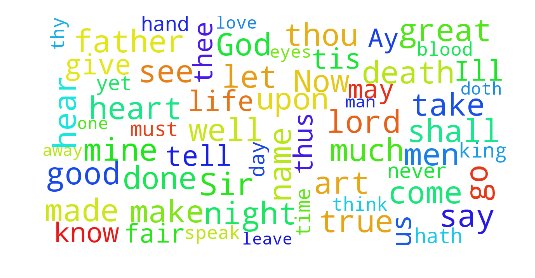

In [2]:
ds = DataSet()
ds.load()

tokens = Processing.get_tokens(ds.df['Utterance'], [Processing.remove_punctuation], [Processing.remove_stopwords])

allWordDist = nltk.FreqDist(tokens)

common_words = allWordDist.most_common(100)

# Print the top 20 words - shows some 'olde english' stop words
print('Hundred most common words:')
print(allWordDist.most_common(100))

cloud_words = ' '.join(entry[0] for entry in common_words)


# lower max_font_size
wordcloud = WordCloud(background_color='white', max_font_size=80,height=600, width=1200).generate(cloud_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png', dpi=200)
plt.show()

<a id='pos_tagging'></a>

## POS Tagging

In order to identify whether POS tagging was effective we concatenated all utterances in all plays. We displayed the ressults of the words that pos_tag deemed as proper nouns for the play Macbeth: the results were disappointing.

In [3]:
plays_utterances = ds.get_by_play()

In [4]:
# Strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
# Requires average_perceptron_tagger from NLTK download
from nltk.tag import pos_tag

for title, text in plays_utterances.items():
    tokens = nltk.word_tokenize(text)
    tagged = pos_tag(tokens) #use NLTK's part of speech tagger
    propernouns = [word for word,pos in tagged if pos == 'NNP' ]

    
    if( title == 'macbeth'):
        print('Play: Macbeth')
        print('Proper Nouns: ',propernouns)



Play: Macbeth
Proper Nouns:  ['Macbeth', 'Graymalkin', 'Paddock', 'Anon', 'Fair', 'Hover', 'Who', 'Hail', 'Say', 'Macdonwald', 'Do', 'Show', 'Macbeth', 'Disdaining', 'Which', 'Till', 'Which', 'Till', 'O', 'Discomfort', 'Mark', 'Scotland', 'Norweyan', 'Began', 'Dismay', 'Macbeth', 'Banquo', 'Or', 'Golgotha', 'Go', 'Ross', 'God', 'Whence', 'Fife', 'Norweyan', 'Norway', 'Cawdor', 'Till', 'Bellona', 'Point', 'Great', 'Sweno', 'Norways', 'Till', 'Saint', 'Colme', 'Cawdor', 'Macbeth', 'Macbeth', 'Sister', "'d", "'d", 'Aleppo', "Thou'rt", 'Hang', 'Shall', 'Wreck', 'Macbeth', 'Posters', 'Thus', 'Speak', 'Macbeth', 'Glamis', 'Macbeth', 'Cawdor', 'Macbeth', 'Are', 'ye', 'Which', 'Speak', 'Macbeth', 'Thou', 'Macbeth', 'Banquo', 'Banquo', 'Macbeth', 'Stay', 'Sinel', 'Glamis', 'Cawdor', 'Cawdor', 'A', 'Stands', 'No', 'Cawdor', 'Say', 'Speak', 'Cawdor', 'Macbeth', 'Thy', 'Which', 'Norweyan', 'Strange', 'As', 'Came', 'Thy', 'Cawdor', 'Cawdor', 'Who', 'Which', 'Norway', 'Glamis', 'Cawdor', 'Cawdor', '

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer




stemmer = SnowballStemmer("english")


def run_tfidf(words, stem=False, max_features=10000):
    all_stopwords = stopwords.words('english') 

    #adding Shakespeare-ean stop-words
    shaksp_stopwords = ('thee', 'thou', 'thy', 'thine')
    all_stopwords += shaksp_stopwords

    tfidf_vectorizer = TfidfVectorizer(#max_features=200000,
                                        max_features=max_features,
                                        min_df=0.2, 
                                        max_df=0.8, 
                                        stop_words=all_stopwords,
                                        use_idf=True, 
                                        tokenizer=tokenize_and_stem if stem else tokenize_only, 
                                        ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(words)
    
    return tfidf_matrix, tfidf_vectorizer.get_feature_names()


def strip_proppers_POS(tokens):
    tagged = pos_tag(tokens) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

    
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems



def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    #filtered_tokens = strip_proppers_POS(filtered_tokens)
    
    return filtered_tokens    
    


### The Data

For our analysis we'll primarily be looking at:
* all the words grouped by plays, plays_utterances below,
* all the words grouped by speakers, speaker_utterances below.


In [6]:
plays_utterances = ds.get_by_play()
tfidf_matrix_plays, terms_plays = run_tfidf(plays_utterances.values())

speakers_utterances = ds.get_by_speaker()
tfidf_matrix_speakers, terms_speakers = run_tfidf(speakers_utterances.values())

In [7]:
#speakers_utterances


<a id='kmeans_details'></a>

## KMeans

In [8]:
from sklearn.cluster import KMeans
from collections import Counter
import pickle


def run_single_kmeans(X, max_iter=300, n_init=10, range_clusters = range(5,6), title=None):
    """
    Run KMeans algorithm for the supplied parameters.
    
    :param tfidf_matrix: the data to cluster on
    :param max_iter: the maximum iterations that KMeans algorithm will run 
    :param n_init=10: the maximum iterations that KMeans algorithm will run 
    :param range_clusters: the clusters to generate
    :param title: the prefix to give to the pickle. If None, do not save the results
    :return: a pandas dataframe with the results of the clustering
    """
    kms = []
    
    for num_clusters in range_clusters:
        #print('KMeans cluster ', num_clusters)

        km = KMeans(n_clusters=num_clusters,
                    init='k-means++',
                    max_iter=max_iter,             # Default is 300
                    n_init=n_init,                 # Default is 10
                    precompute_distances=True, # Faster but takes more memory
                    random_state=47,
                    n_jobs=-1)

        cluster_labels = km.fit(X)

        kms.append( {'num_clusters': num_clusters, 
                    'cluster_centers':km.cluster_centers_, 
                    'clusters':km.labels_.tolist(), 
                    'inertia':km.inertia_,
                    'cluster_labels': km.labels_ })
    
    kms_df = pd.DataFrame(kms, index=range_clusters)

    if title is not None:
        kms_df.to_pickle('kms_{}_{}_{}.pickle'.format(title, max_iter, n_init))
        
    return kms_df


            
            
def run_kmeans(tfidf_matrix, max_clusters, title=None):
    """
    Run a grid search to identify whether changing max_iters 
    and n_inits has a bit influence on the result.
    """
    max_iters = [1, 10, 100, 300, 1000, 10000]
    n_inits = [1, 5, 10, 50, 100]
    range_clusters = range(1, max_clusters)
    
    kms_df = None
    
    for max_iter in max_iters:
        print('Max iter: ', max_iter)
        for n_init in n_inits:
            print('n_init: ', n_init)
          
            run_single_kmeans(tfidf_matrix, max_iter, n_init, title=title)
    

            

# The following lines are deliberately commented out
# They will find the hyper-parameters for max_iters and n_init
#run_kmeans(tfidf_matrix_plays, len(plays_utterances))
#run_kmeans(tfidf_matrix_plays, len(speakers_utterances))





Run a KMeans on the plays. We will first run kmeans with max_iter=1, n_init=10 and then with max_iter=1, n_init=10

In [9]:
# Run a KMeans on the plays with max_iter=1, n_init=10 - for comparison
run_single_kmeans(tfidf_matrix_plays, 
                                 max_iter=1, n_init=10, range_clusters = range(1,6), title='plays')

# Run again using a decent max_iter and n_init
kms_df_plays = run_single_kmeans(tfidf_matrix_plays, 
                                 range_clusters = range(1,6), title='plays')

In [10]:
# Run K-Means with k = max (971) - will take a long time
if False:
    size_speakers = tfidf_matrix_speakers.shape[0]

    # Run a KMeans on the speakers with max_iter=1, n_init=10 - for comparison
    run_single_kmeans(tfidf_matrix_speakers, 
                        max_iter=1, n_init=10, 
                        range_clusters = range(1,size_speakers), title='speakers')

    # Run again using a decent max_iter and n_init
    kms_df_speakers = run_single_kmeans(tfidf_matrix_speakers, 
                                        range_clusters = range(1,size_speakers), title='speakers')

kms_df_speakers1_10 = run_single_kmeans(tfidf_matrix_speakers, 
                                    max_iter=1, n_init=10,
                                    range_clusters = range(1,100), title='speakers')

kms_df_speakers = run_single_kmeans(tfidf_matrix_speakers, 
                                    range_clusters = range(1,100), title='speakers')

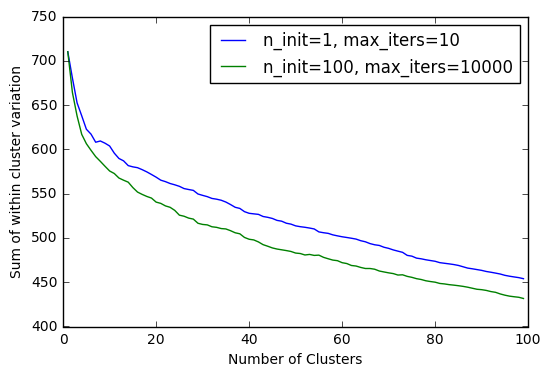

In [11]:

def plot_two(kms1, label1, kms2, label2):
    fig, ax = plt.subplots()
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of within cluster variation')
    plt.plot(kms1.num_clusters, kms1.inertia, label=label1)
    plt.plot(kms2.num_clusters, kms2.inertia, label=label2)
    plt.legend(loc='upper right')
    plt.savefig('km_variation_both.png', dpi=200)
    plt.show()


# For the plays, plot the variation as a fn of the number of clusters
# Compare the difference when running with
#  i) n_init=1, max_iters=10
# ii) n_init=100, max_iters=10000

plot_two(kms_df_speakers1_10, 'n_init=1, max_iters=10', kms_df_speakers, 'n_init=100, max_iters=10000')




In [12]:
def make_frame(utterances, clusters):

    plays_dict = { 'title': list(utterances.keys()),'cluster': clusters}

    frame = pd.DataFrame(plays_dict, index = [clusters] , columns = [
            'title', 'cluster'])
    return frame

    

frame_plays = make_frame(plays_utterances, kms_df_plays.iloc[3].clusters)

# From the diagram, above, it looks like there may be an elbow around 5
frame_speakers = make_frame(speakers_utterances, kms_df_speakers.iloc[4].clusters)


In [13]:

# totalvocab_stemmed = []
# totalvocab_tokenized = []
# for i in plays_utterances.values():
#     allwords_stemmed = tokenize_and_stem(i)
#     totalvocab_stemmed.extend(allwords_stemmed)
    
#     allwords_tokenized = tokenize_only(i)
#     totalvocab_tokenized.extend(allwords_tokenized)


In [31]:
 def top_terms(frame, km, terms):
    print("Top terms per cluster:")
    print()
    order_centroids = km.cluster_centers.argsort()[:, ::-1]
    for i in range(km.num_clusters):

        print("Cluster {} words:".format(i))
        all_terms = ''
        for ind in order_centroids[i, :10]:
            all_terms += ' {},'.format(terms[ind])
        print(all_terms)
        print()

        print("Cluster {} titles:".format(i))
        all_titles = ''
        for title in frame['title'].values.tolist():
            all_titles += ' {},'.format(title)
        print(all_titles)
        print()
        print()
    

top_terms(frame_plays, kms_df_plays.iloc[3], terms_plays)
#top_terms(frame_speakers, kms_df_speakers.iloc[4], terms_speakers)

Top terms per cluster:

Cluster 0 words:
 france, henry, york, england, duke, edward, richard, majesty, gloucester, de,

Cluster 0 titles:
 merchant, coriolan, t_night, troilus, tempest, cymbelin, timon, hen_iv_2, all_well, win_tale, hamlet, j_caesar, much_ado, dream, lll, macbeth, pericles, r_and_j, rich_ii, titus, hen_vi_2, as_you, m_for_m, hen_vi_1, john, rich_iii, hen_vi_3, com_err, lear, othello, two_gent, hen_iv_1, a_and_c, hen_viii, hen_v, m_wives, taming,


Cluster 1 words:
 duke, signior, letter, count, friar, ring, ducats, chain, court, cousin,

Cluster 1 titles:
 merchant, coriolan, t_night, troilus, tempest, cymbelin, timon, hen_iv_2, all_well, win_tale, hamlet, j_caesar, much_ado, dream, lll, macbeth, pericles, r_and_j, rich_ii, titus, hen_vi_2, as_you, m_for_m, hen_vi_1, john, rich_iii, hen_vi_3, com_err, lear, othello, two_gent, hen_iv_1, a_and_c, hen_viii, hen_v, m_wives, taming,


Cluster 2 words:
 gods, caesar, rome, prithee, hector, general, brutus, 'em, to-night, mo

<a id='mds_details'></a>

## MDS

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()

def calc_mds(tfidf_matrix):
    dist = 1 - cosine_similarity(tfidf_matrix)

    # two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]
    
    return dist, xs, ys

dist_plays, xs_plays, ys_plays = calc_mds(tfidf_matrix_plays)
dist_speakers, xs_speakers, ys_speakers = calc_mds(tfidf_matrix_speakers)

In [16]:
#set up cluster names using a dict
cluster_names_plays = {0: 'Tragedies', 
                 1: 'Comedies', 
                 2: 'Roman', 
                 3: 'History'}

cluster_names = {0: '0', 
                 1: '1', 
                 2: '2', 
                 3: '3', 
                 4: '4'}

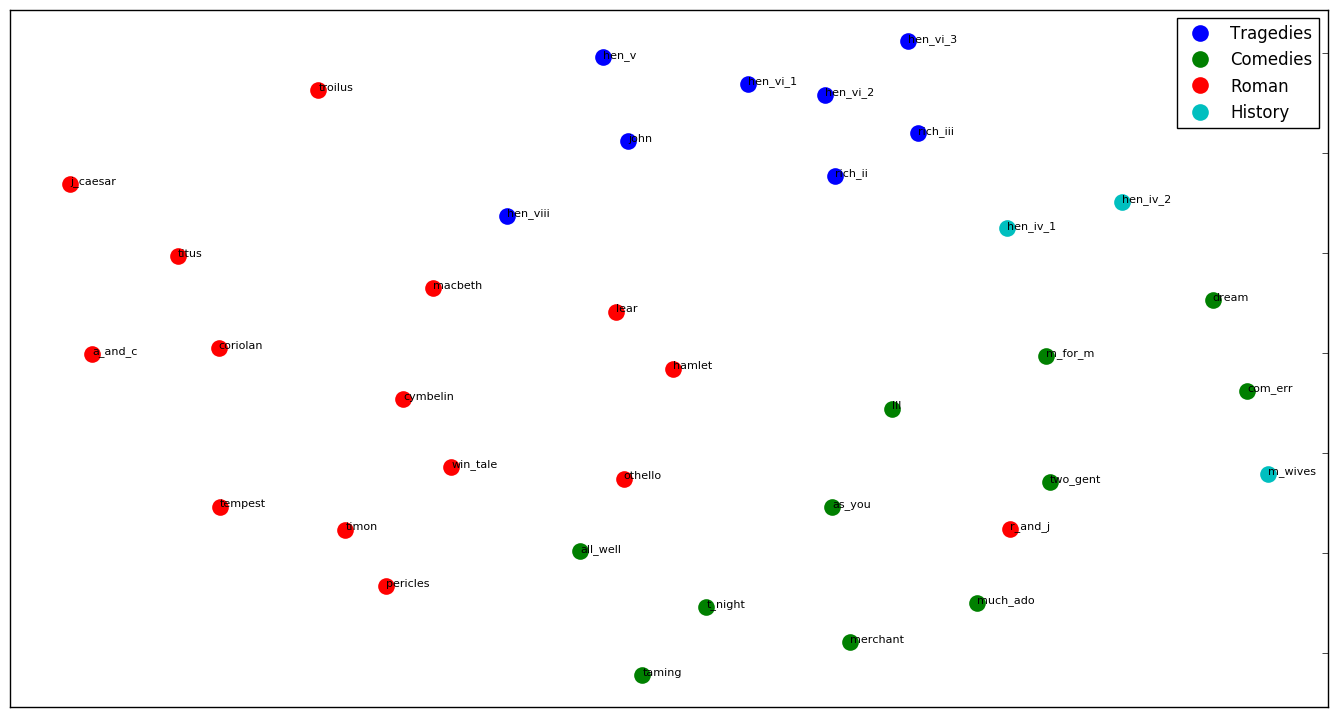

In [17]:
%matplotlib inline

def display_mds_plot(frame, xs, ys, cluster_names, cluster_colors=None):
    """
    Based on code from: http://brandonrose.org/clustering
    """
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=frame['cluster'], title=frame['title'])) 

    #group by cluster
    groups = df.groupby('label')


    # set up plot
    fig, ax = plt.subplots(figsize=(17,9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that we use the cluster_name and cluster_color dicts with the 'name' lookup to return t
    #he appropriate color/label
    for name, group in groups:
        
        if cluster_colors is None:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                    label=cluster_names[name], 
                    mec='none')
        else:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                    label=cluster_names[name], 
                    color=cluster_colors[name],
                    mec='none')
            
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    #add label in x,y position with the label as the film title
    for i, row in df.iterrows():
        ax.text(row['x'], row['y'], row['title'], size=8)  



    plt.show() #show the plot

    #uncomment the below to save the plot if need be
    #plt.savefig('clusters_small_noaxes.png', dpi=200)
    
display_mds_plot(frame_plays, xs_plays, ys_plays, cluster_names_plays)


The same technique used on the speakers doesn't work as well as there are too many points (972 speakers) and although there appears to be a pattern it's hard to interpret as the labels overlap.

<a id='hdc_details'></a>

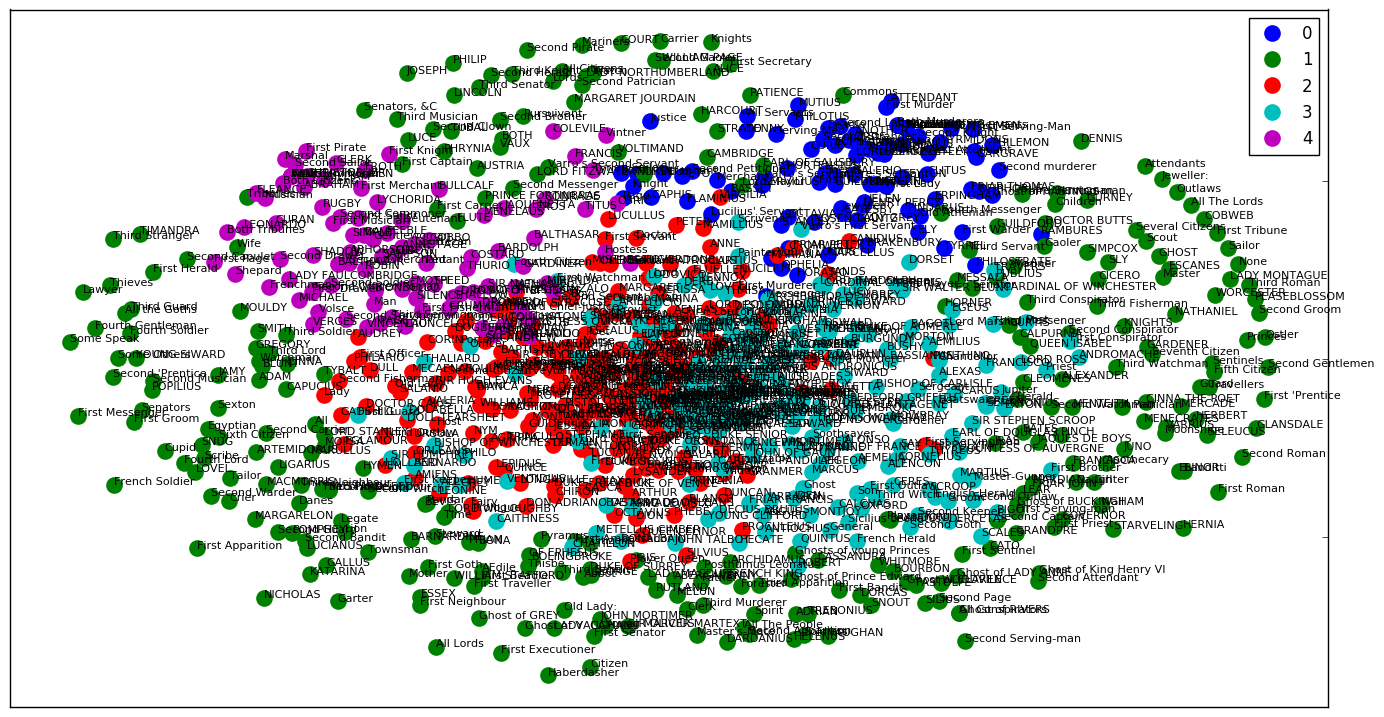

In [18]:
display_mds_plot(frame_speakers, xs_speakers, ys_speakers, cluster_names)

Instead, we'll reduce the number of speakers to only the important ones (defined as speaking more than 10,000 words)

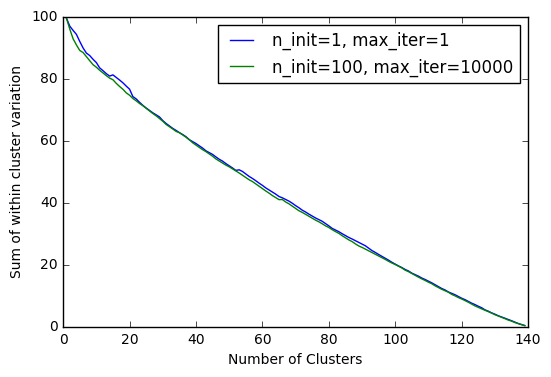

In [19]:
def reduce_by( df, limit=10000):
    df2 = {}
    for key in df.keys():
        if( len(df[key]) > limit ):
            df2[key] = df[key]
            
    return df2



#plays_utterances = ds.get_by_play()
reduced_speakers_utterances = reduce_by(speakers_utterances)

tfidf_matrix_speakers_reduced, terms_speakers_reduced = run_tfidf(reduced_speakers_utterances.values())


# Run using poor parameters
kms_df_speakers_reduced1_1 = run_single_kmeans(tfidf_matrix_speakers_reduced, 
                                             n_init=1, max_iter=1,
                                             range_clusters = range(1,tfidf_matrix_speakers_reduced.shape[0]), 
                                               title='speakers')
    
# Run again using a decent max_iter and n_init
kms_df_speakers_reduced = run_single_kmeans(tfidf_matrix_speakers_reduced, 
                                         range_clusters = range(1,tfidf_matrix_speakers_reduced.shape[0]),
                                         title='speakers')

plot_two(kms_df_speakers_reduced1_1, 'n_init=1, max_iter=1', 
         kms_df_speakers_reduced, 'n_init=100, max_iter=10000')


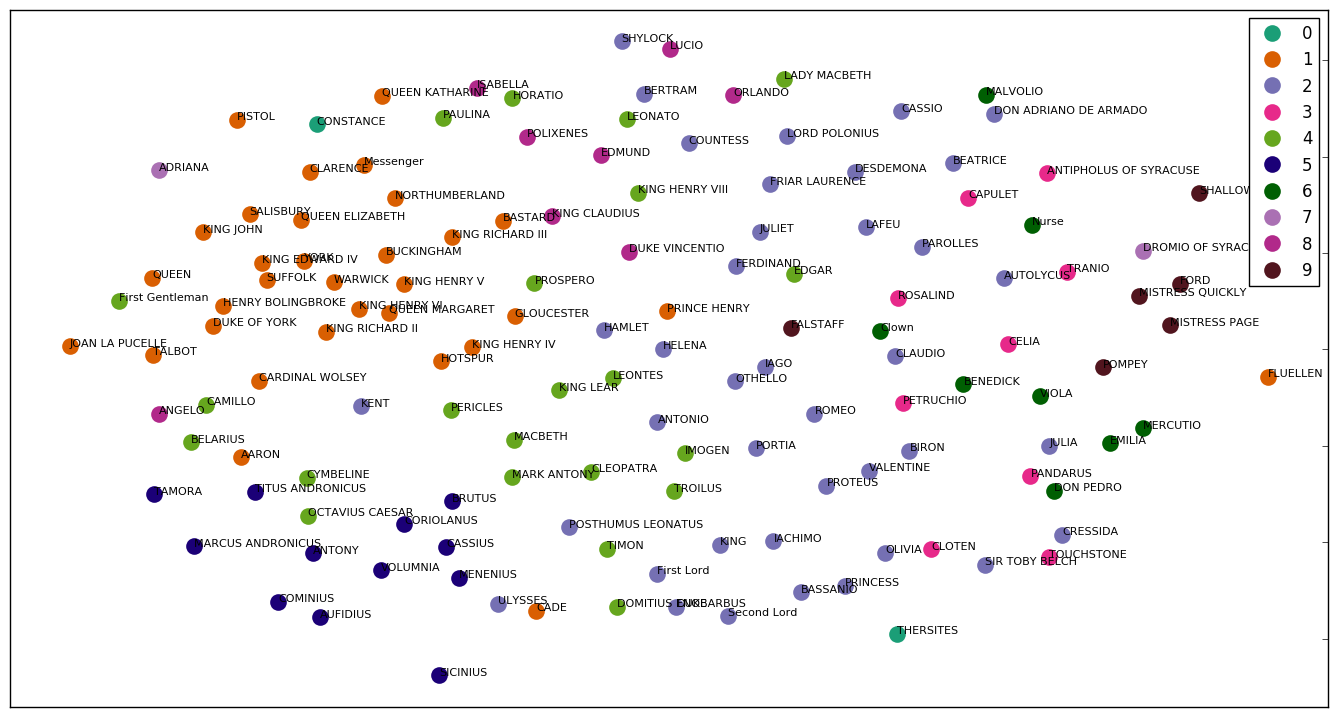

In [20]:

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#1b0077', 6: '#005f02', 7: '#AA70b3', 8: '#b1298a', 9: '#51151e'}

cluster_names_play_stem = {0: '0', 
                           1: '1', 
                           2: '2', 
                           3: '3',
                           4: '4',
                           5: '5',
                           6: '6',
                           7: '7',
                           8: '8',
                           9: '9'}

# From the diagram, above, it looks like there may be an elbow around 4
frame_speakers_reduced = make_frame(reduced_speakers_utterances, kms_df_speakers_reduced.iloc[9].clusters)


dist_speakers_reduced, xs_speakers_reduced, ys_speakers_reduced = calc_mds(tfidf_matrix_speakers_reduced)


display_mds_plot(frame_speakers_reduced, 
                 xs_speakers_reduced, 
                 ys_speakers_reduced,
                 cluster_names_play_stem, 
                 cluster_colors = cluster_colors)


<a id='dendogram_details'></a>

## Hierarchical Document Clustering

In [21]:
# Based on ideas in:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

def display_dendogram(X, labels, method, metric='euclidean', cutoff=None):
    # For distance see https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.distance.pdist.html
    # For method see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html
    
    
    #Z = linkage(X, method='single', metric='chebyshev')
    Z = linkage(X, method, metric)

    # Calculate the Cophenetic Correlation Coefficient - a value close to 1 is good!
    c, coph_dists = cophenet(Z, pdist(X))
    print('Cophenetic Correlation Coefficient: ', c)
    
    

    # calculate full dendrogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        labels=labels,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=10.,  # font size for the x axis labels
    )
    
    if cutoff is not None:
        plt.axhline(y=cutoff, c='k')
    plt.show()



### Running with different metrics

The distance metric is specified by the <code>metric</code> parameter and details of all parameters can be found at https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.distance.pdist.html. Note that not all methods use all the distance metrics.

We investigate the effect the paramter has on single linkage.

Method: Single, Metric:  euclidean
Cophenetic Correlation Coefficient:  0.626610269682


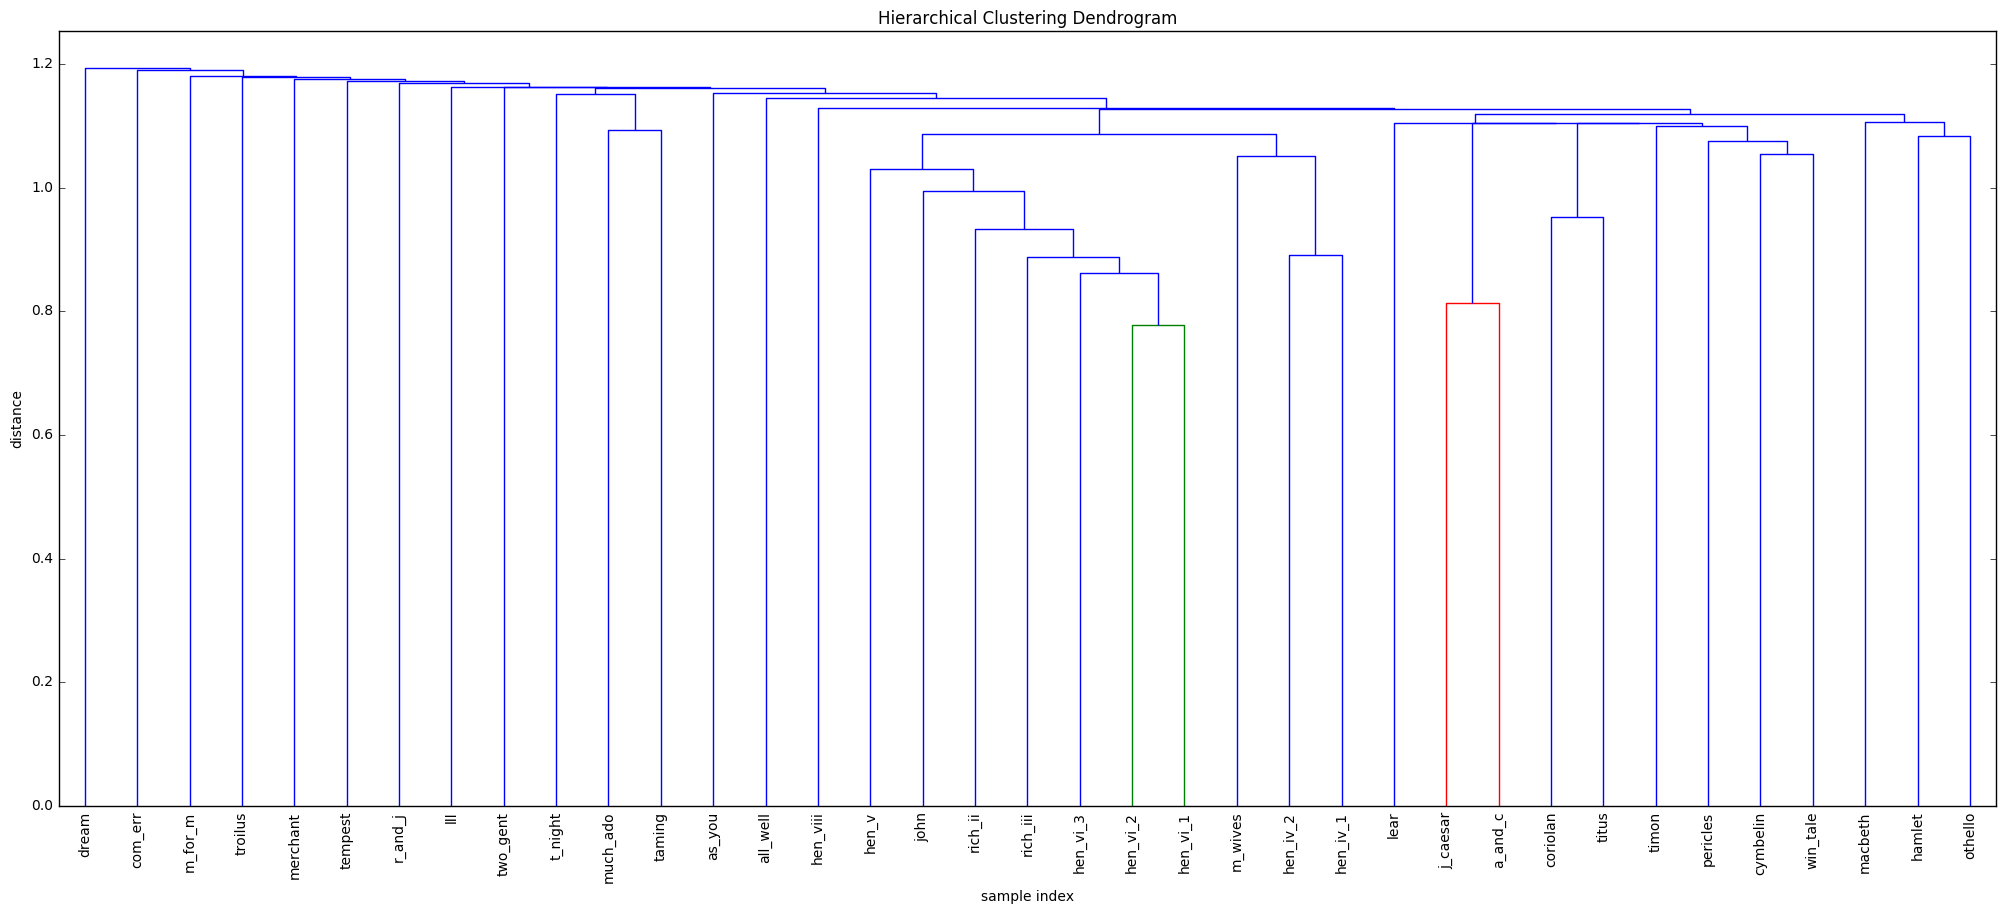

Method: Single, Metric:  minkowski
Cophenetic Correlation Coefficient:  0.626610269682


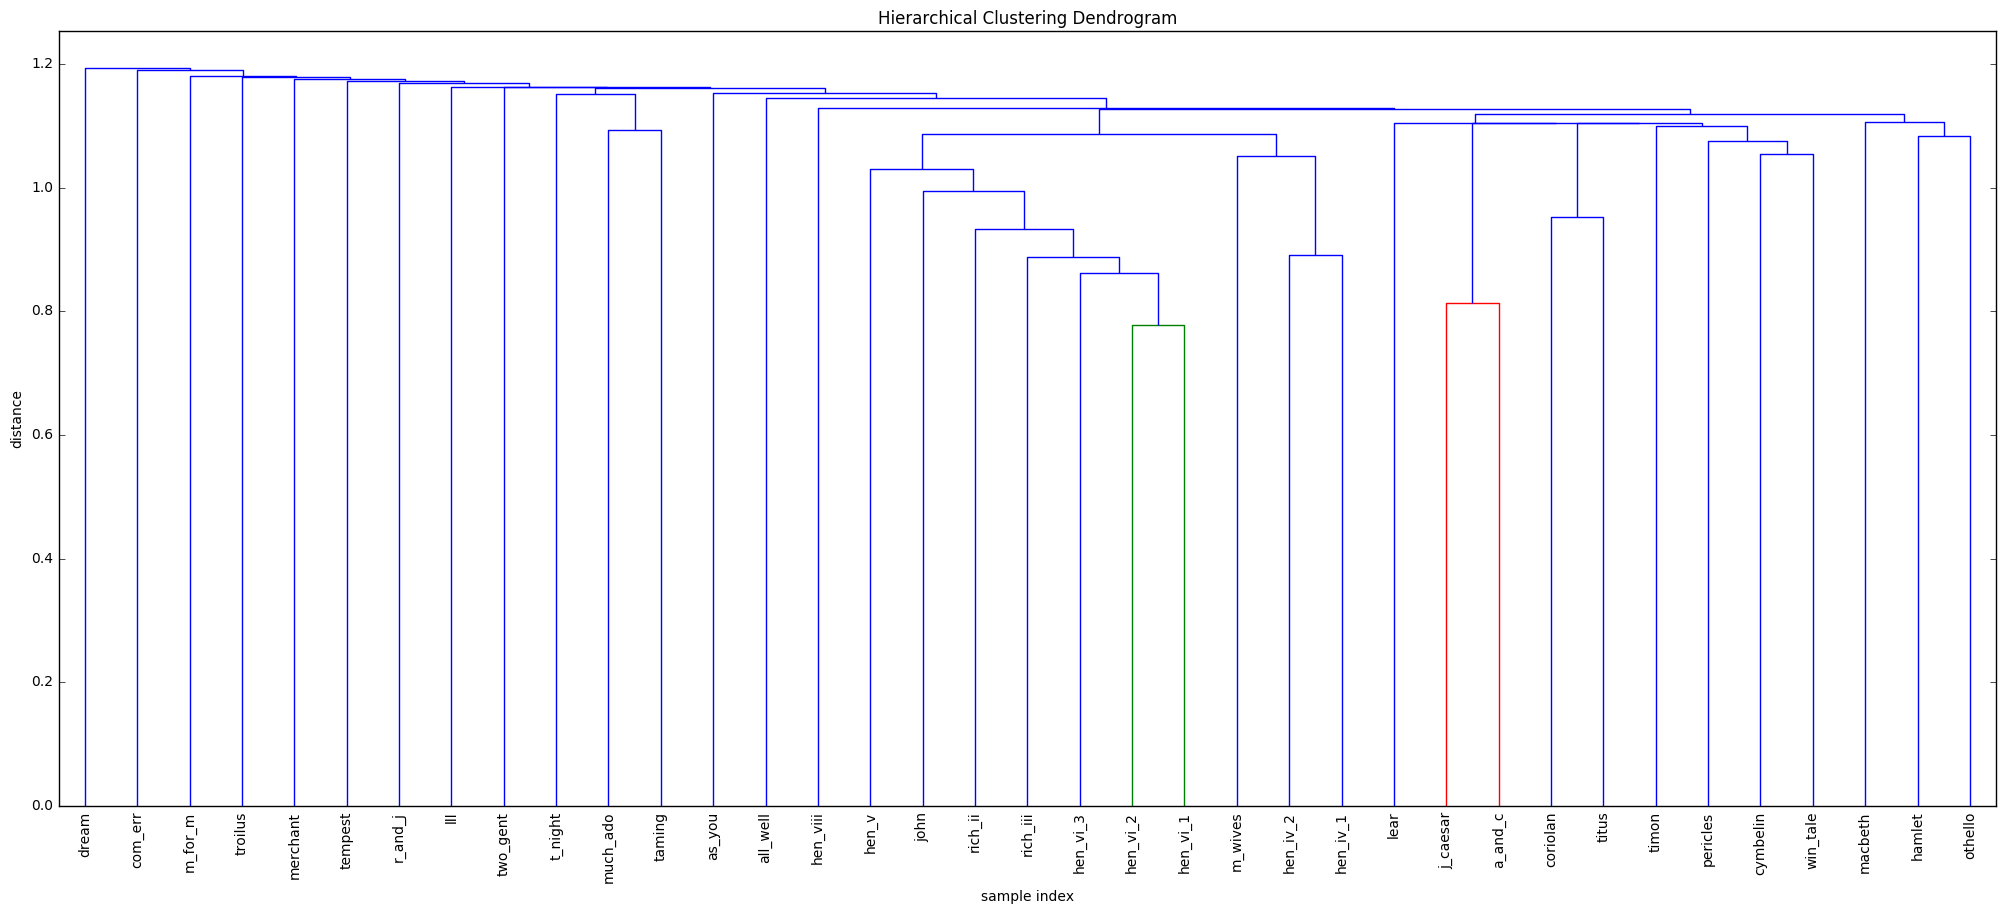

Method: Single, Metric:  cityblock
Cophenetic Correlation Coefficient:  -0.190039845913


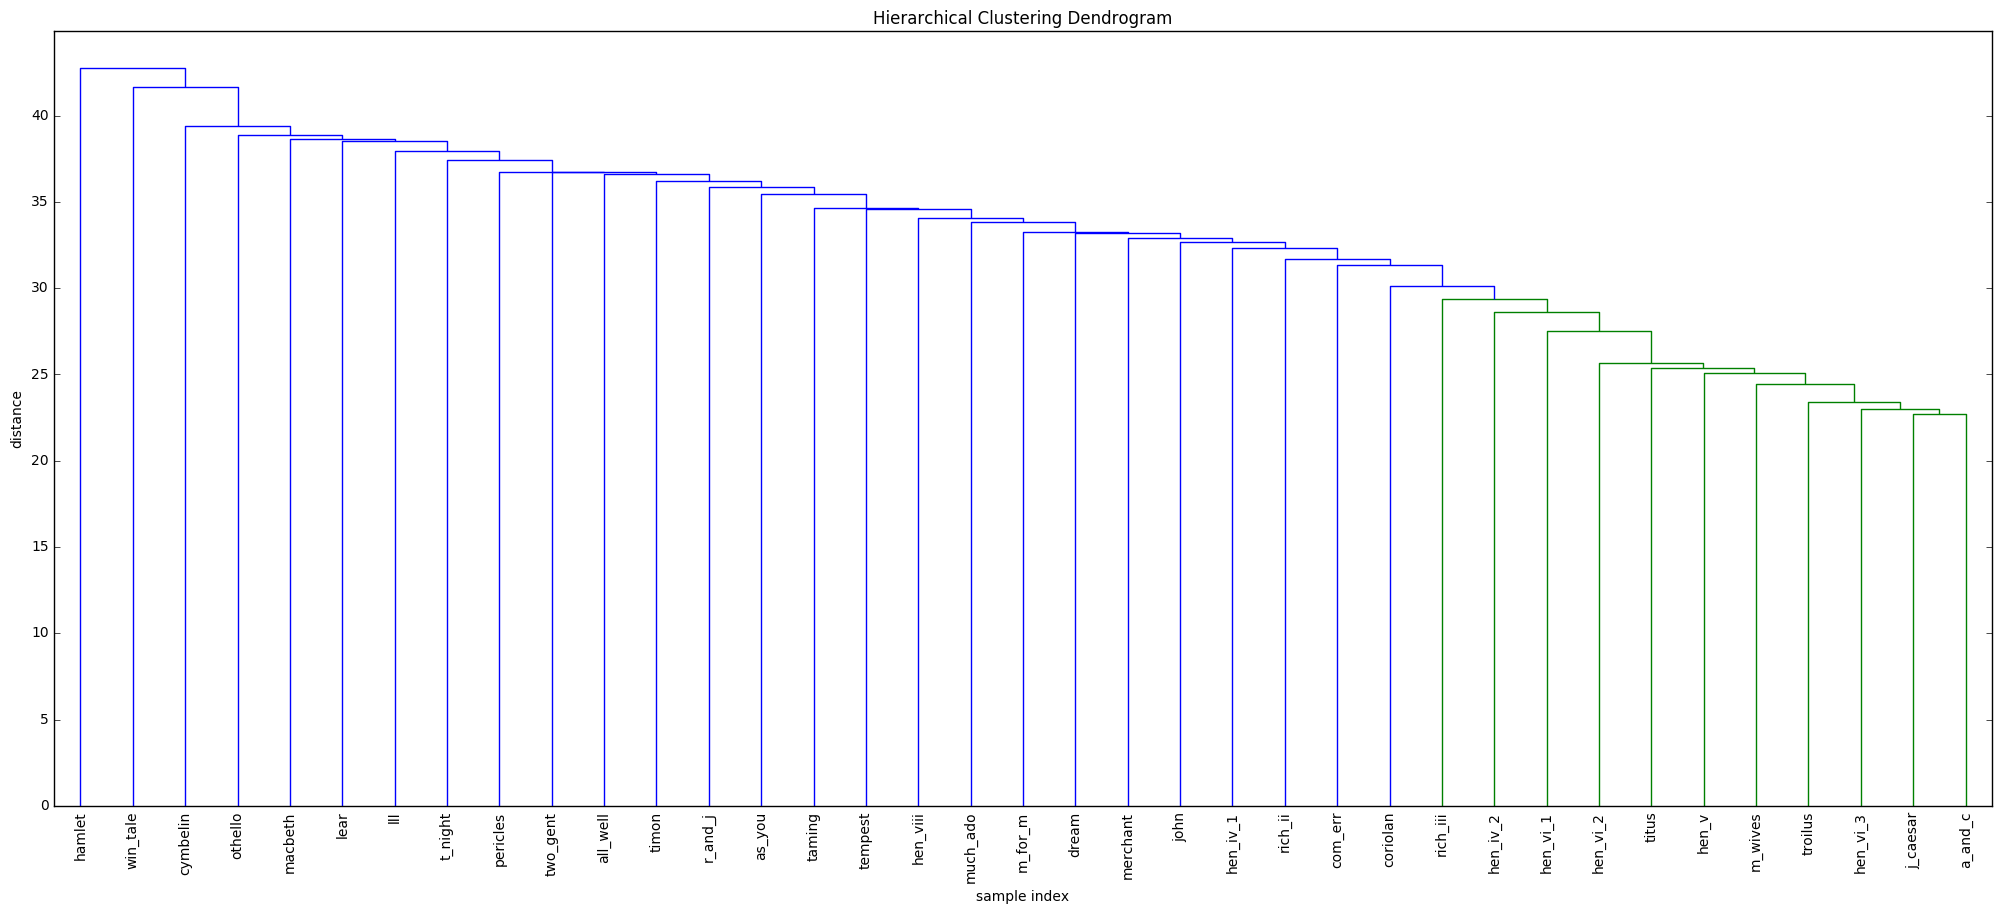

Method: Single, Metric:  seuclidean
Cophenetic Correlation Coefficient:  -0.118722992863


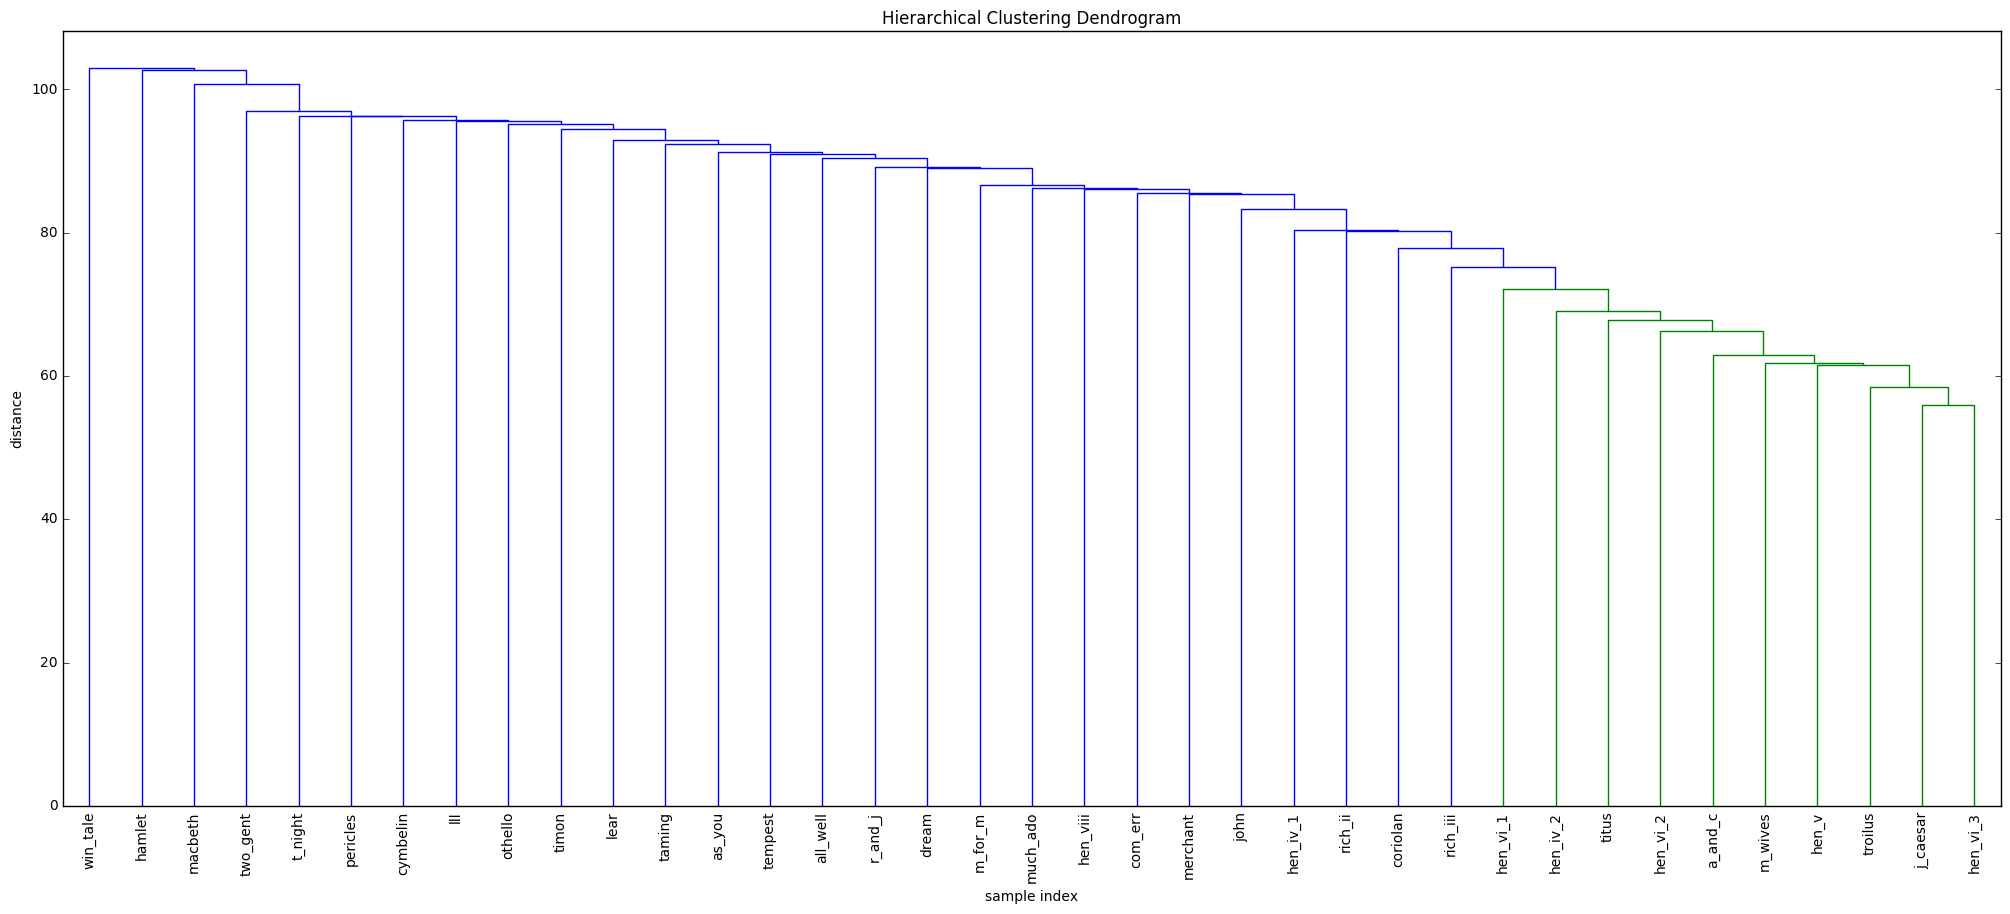

Method: Single, Metric:  sqeuclidean
Cophenetic Correlation Coefficient:  0.613134741342


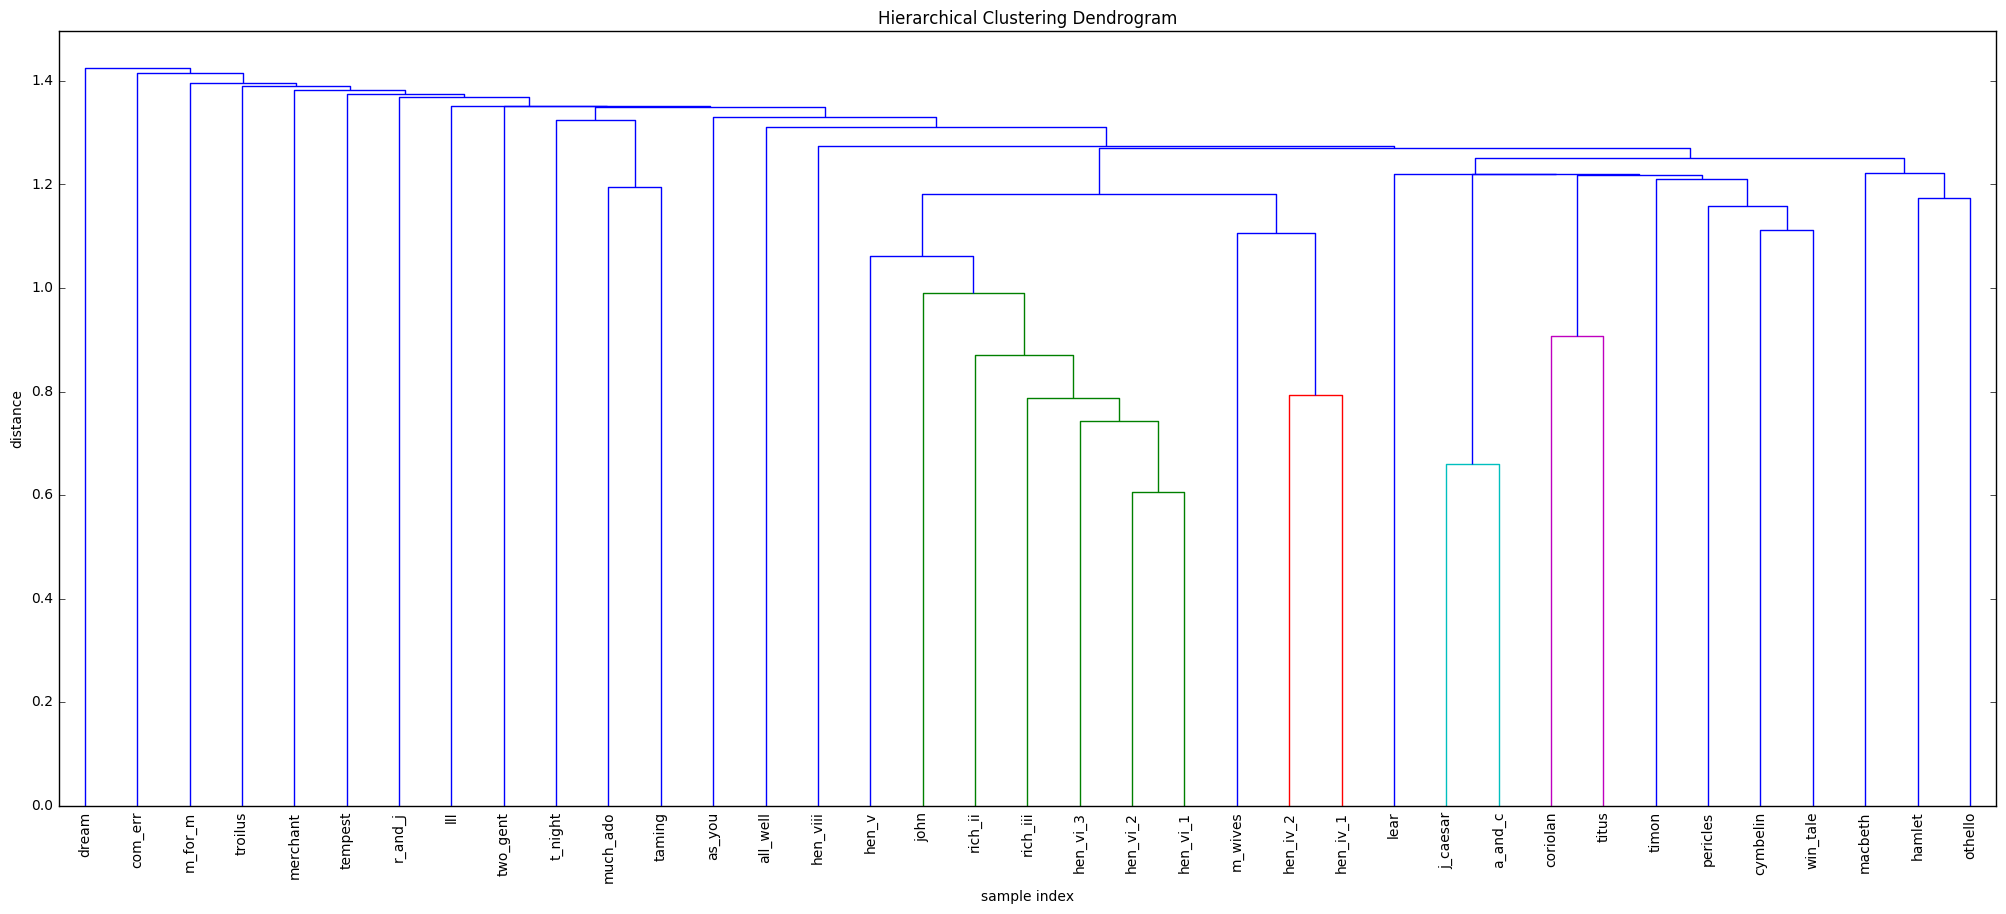

Method: Single, Metric:  cosine
Cophenetic Correlation Coefficient:  0.613134741342


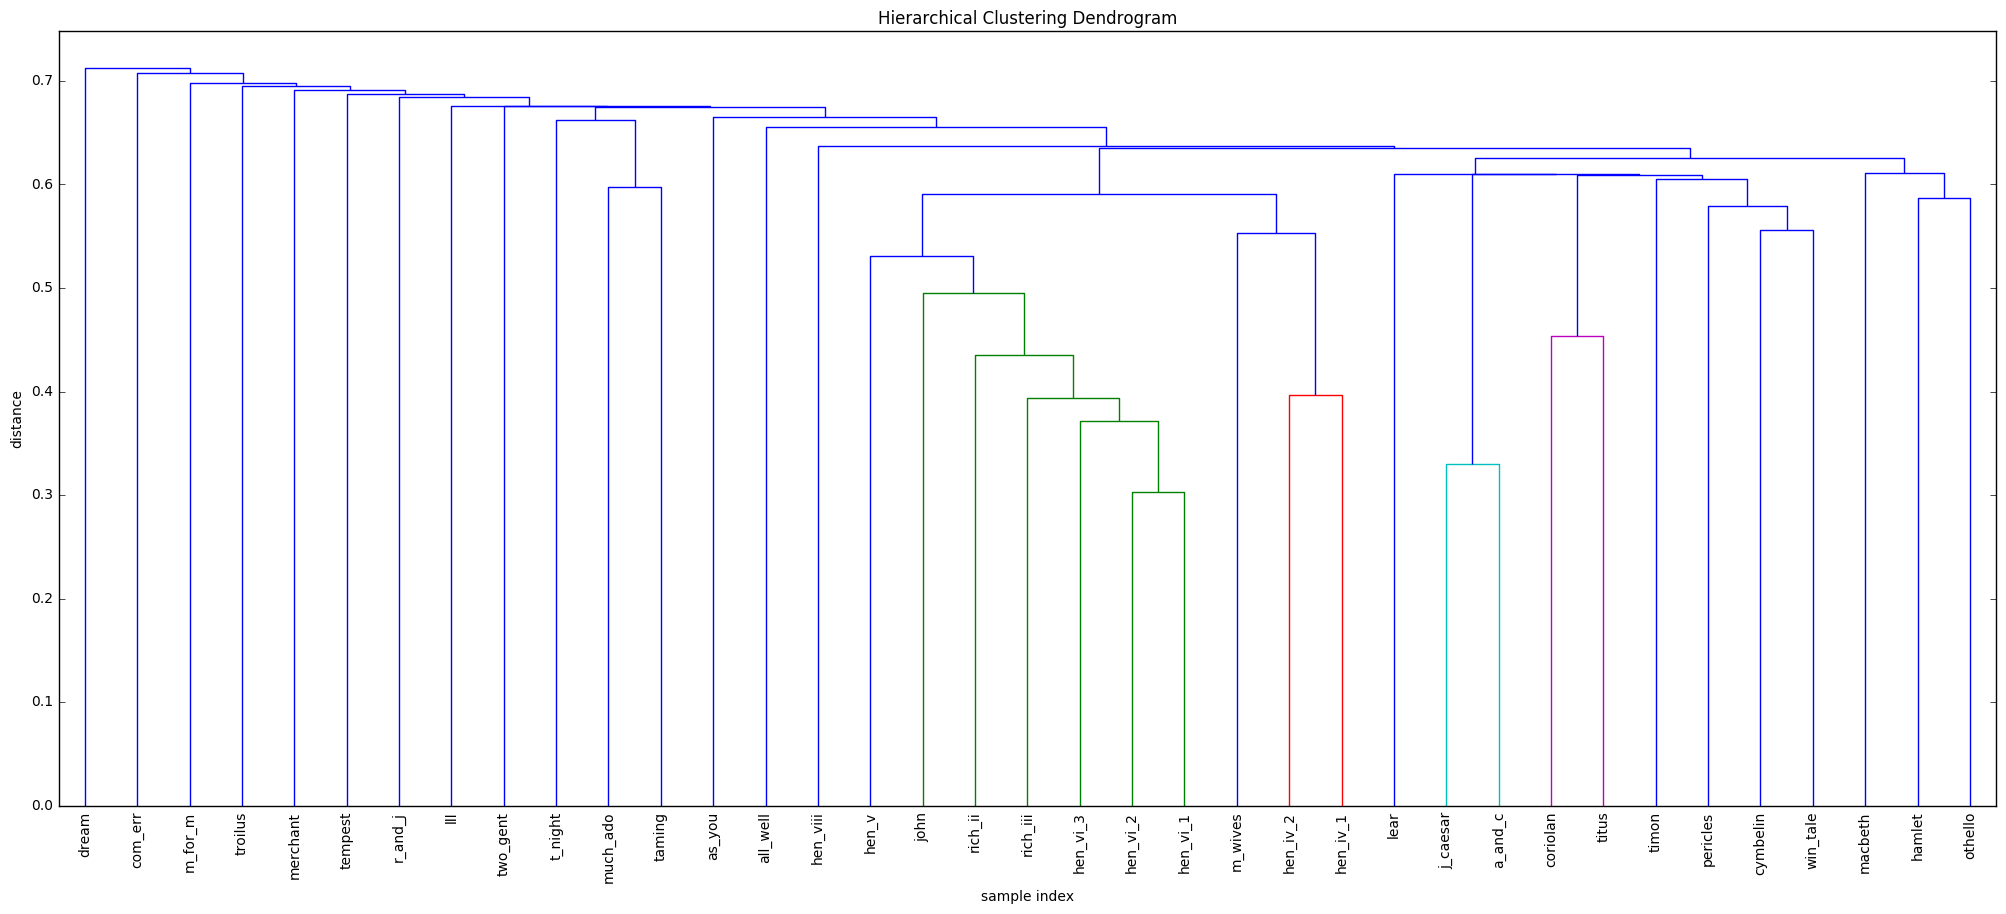

Method: Single, Metric:  correlation
Cophenetic Correlation Coefficient:  0.627711477783


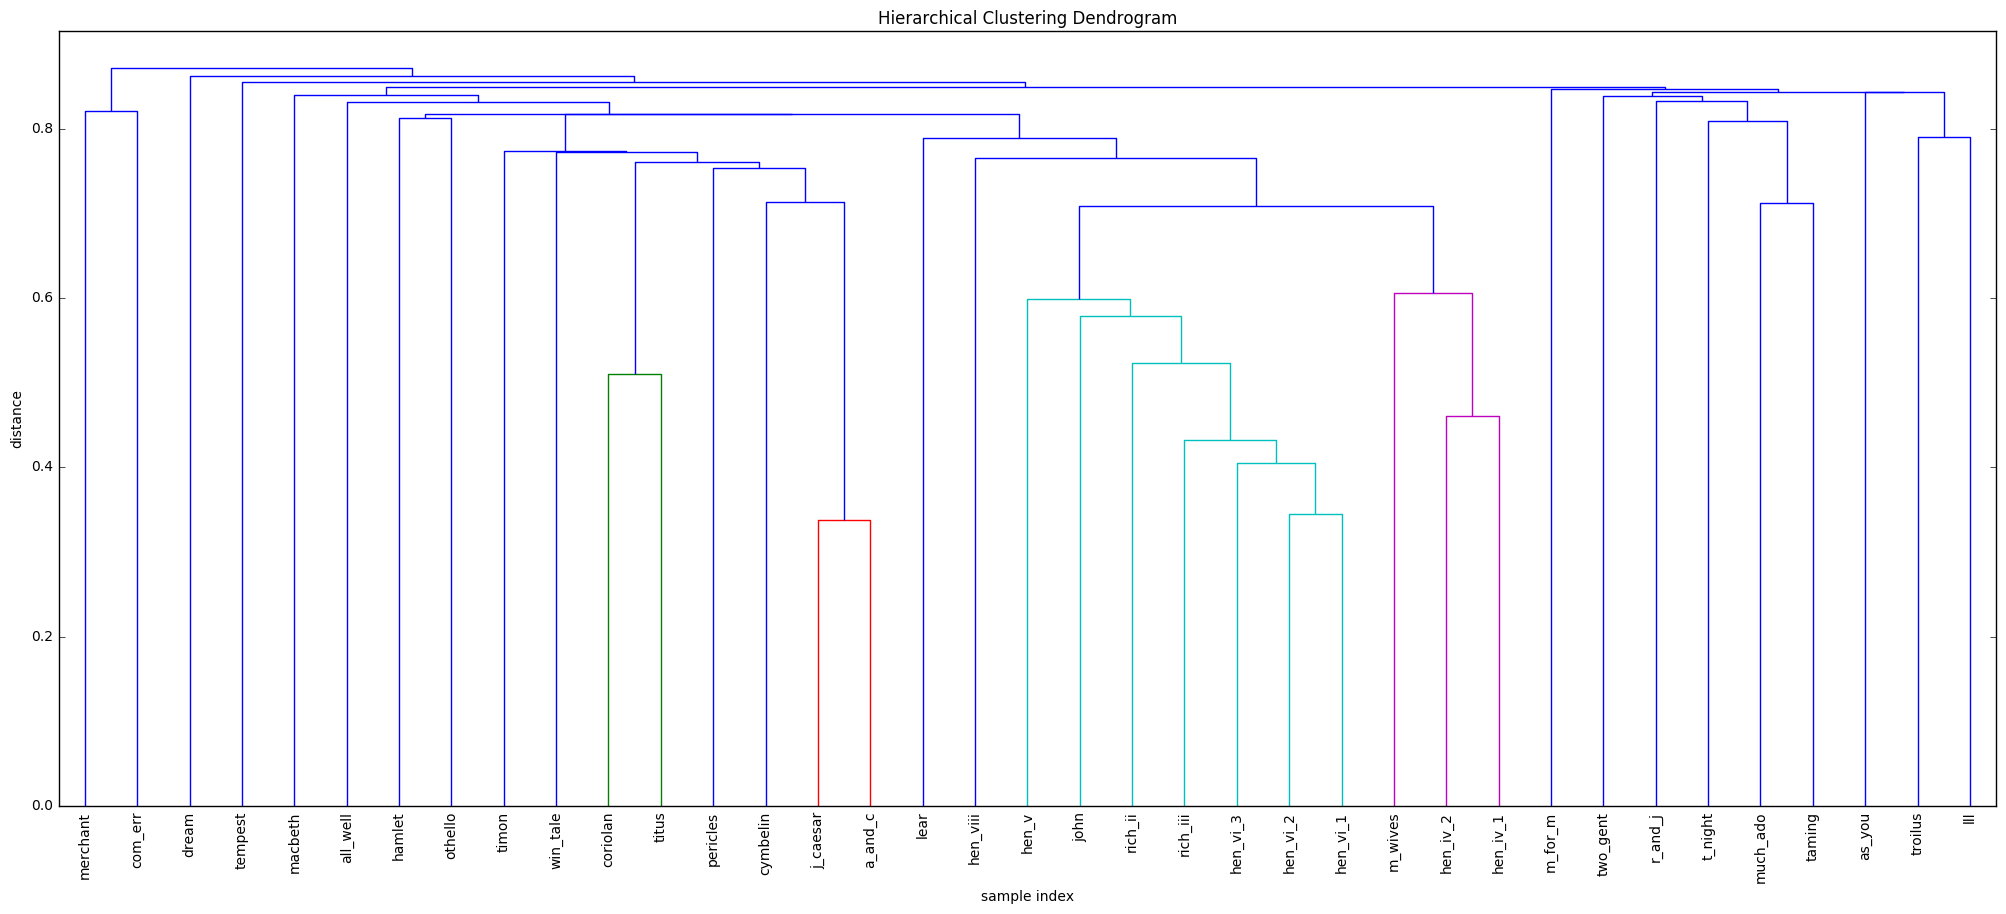

Method: Single, Metric:  hamming
Cophenetic Correlation Coefficient:  -0.250333125396


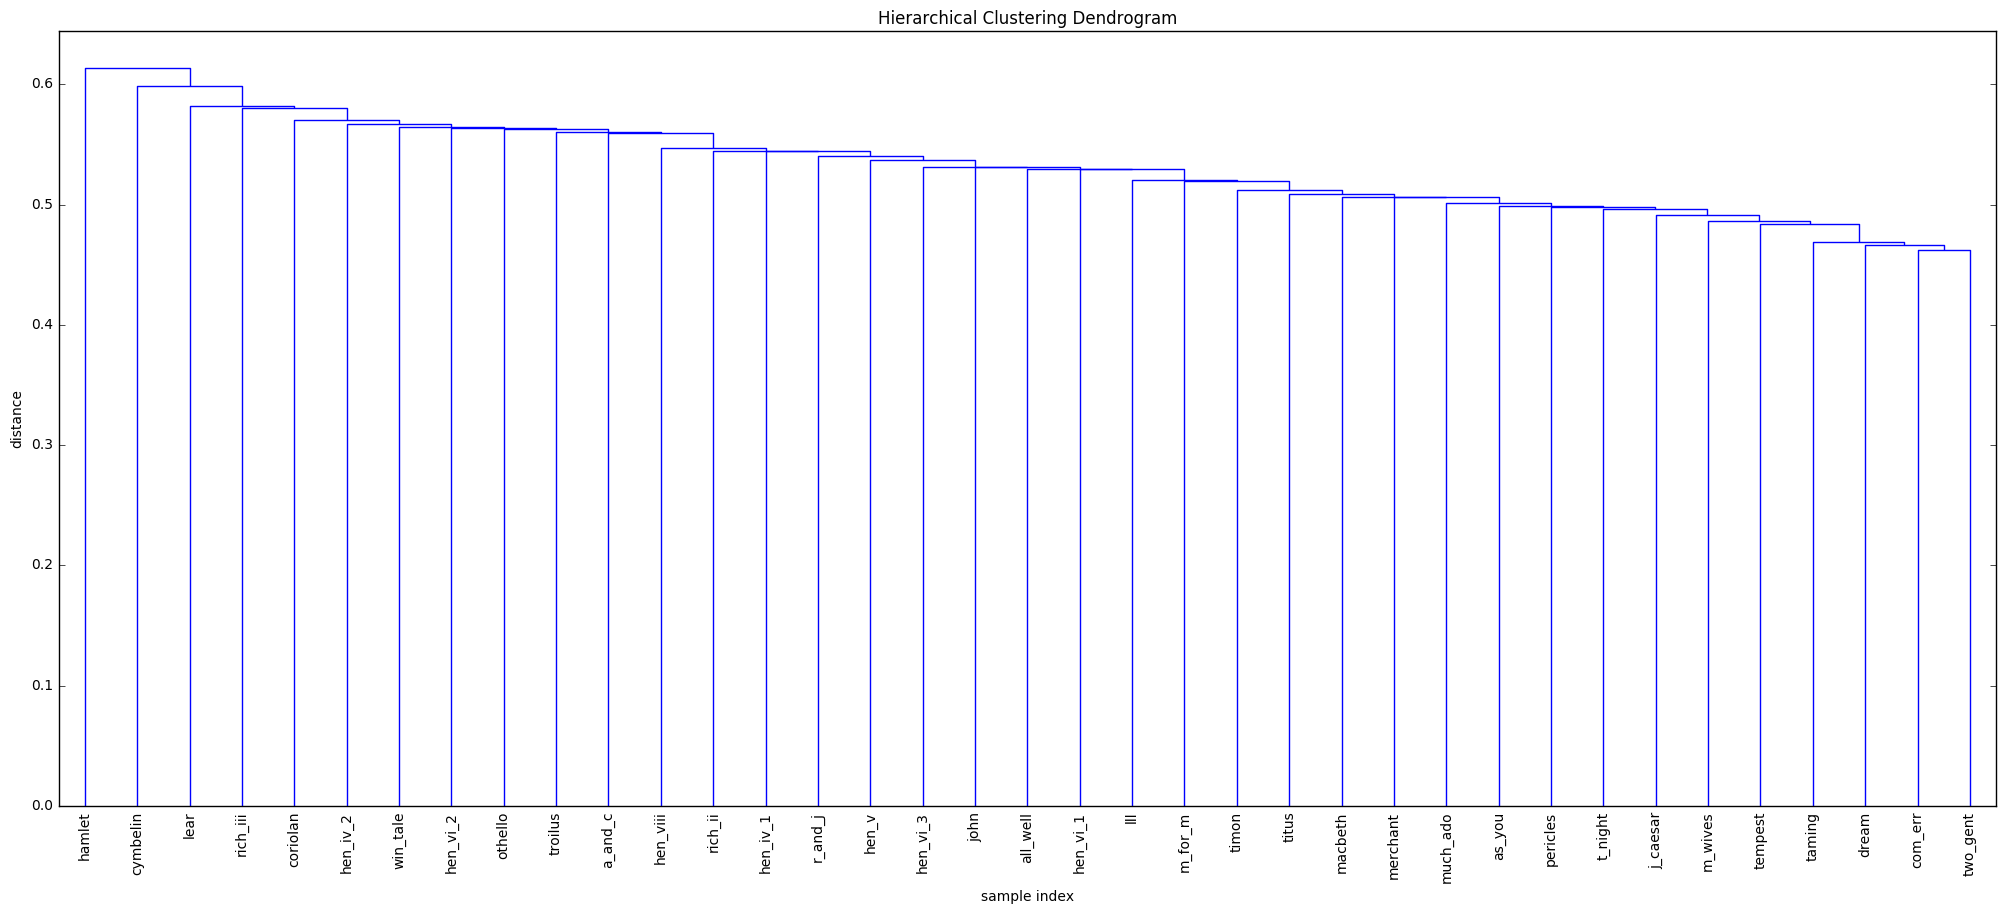

Method: Single, Metric:  jaccard
Cophenetic Correlation Coefficient:  nan


/usr/local/anaconda3/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:1119: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


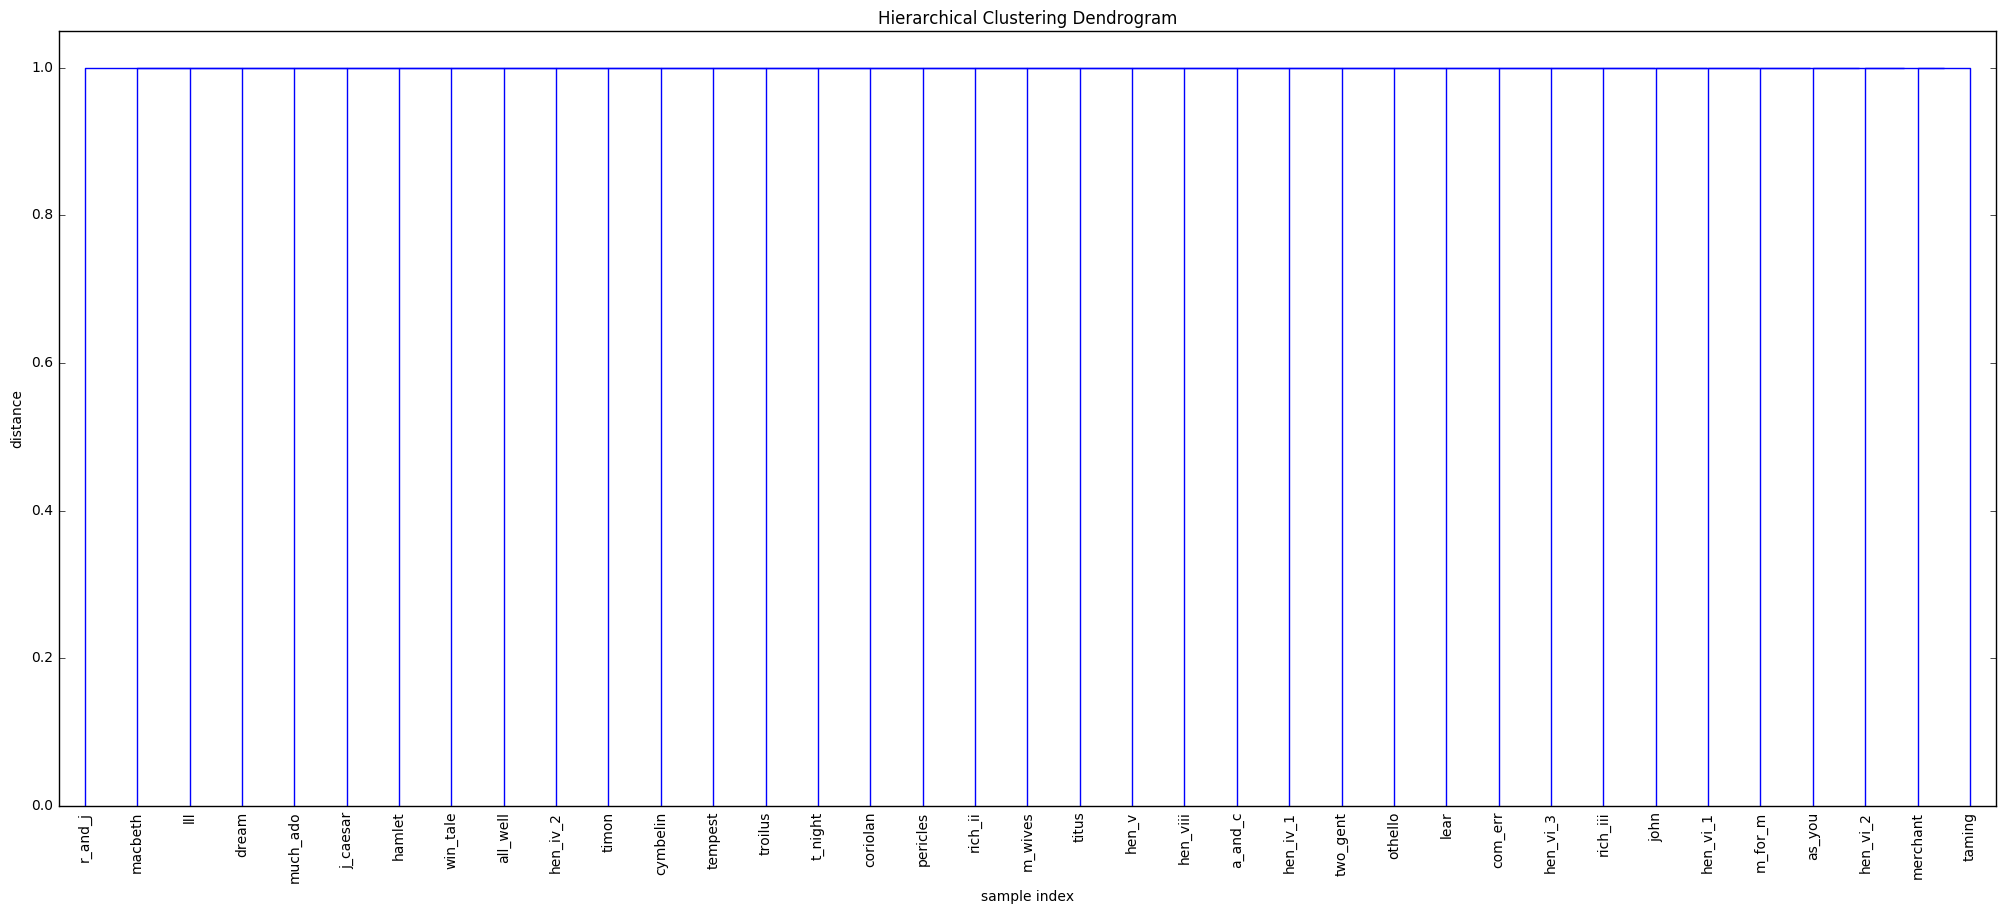

Method: Single, Metric:  yule
Cophenetic Correlation Coefficient:  0.548517782628


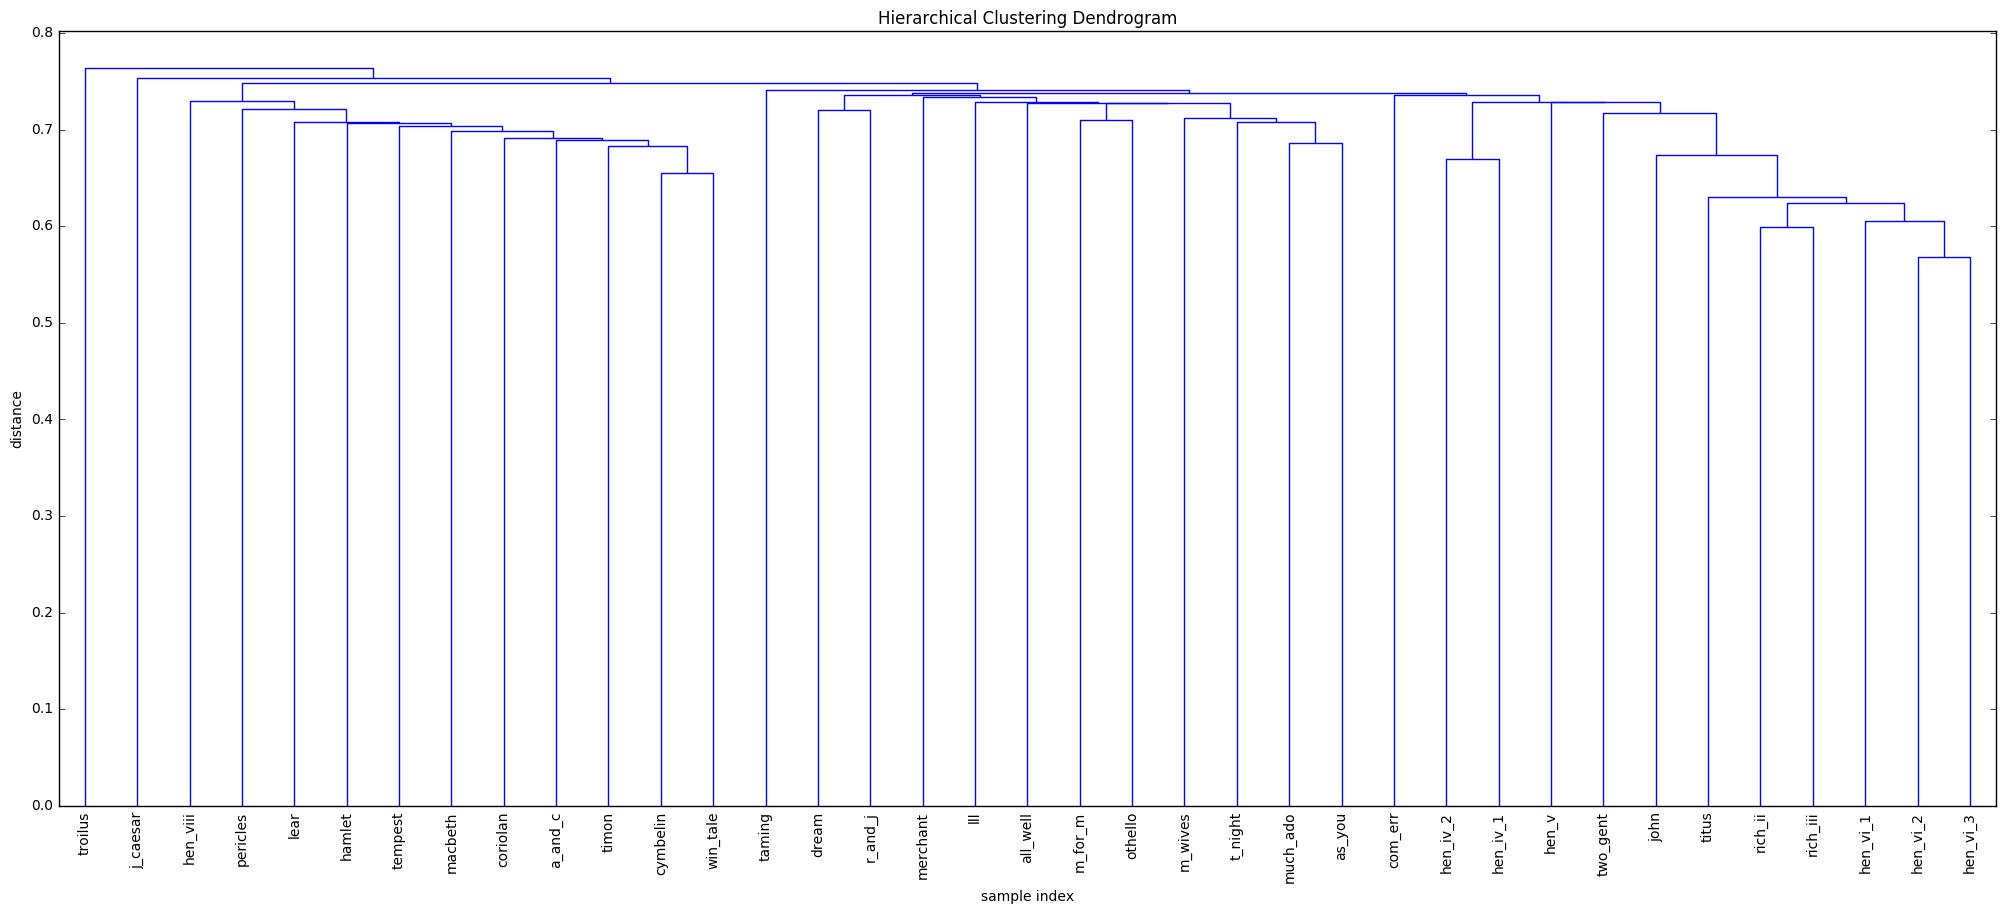

Method: Single, Metric:  matching
Cophenetic Correlation Coefficient:  -0.0746786784753


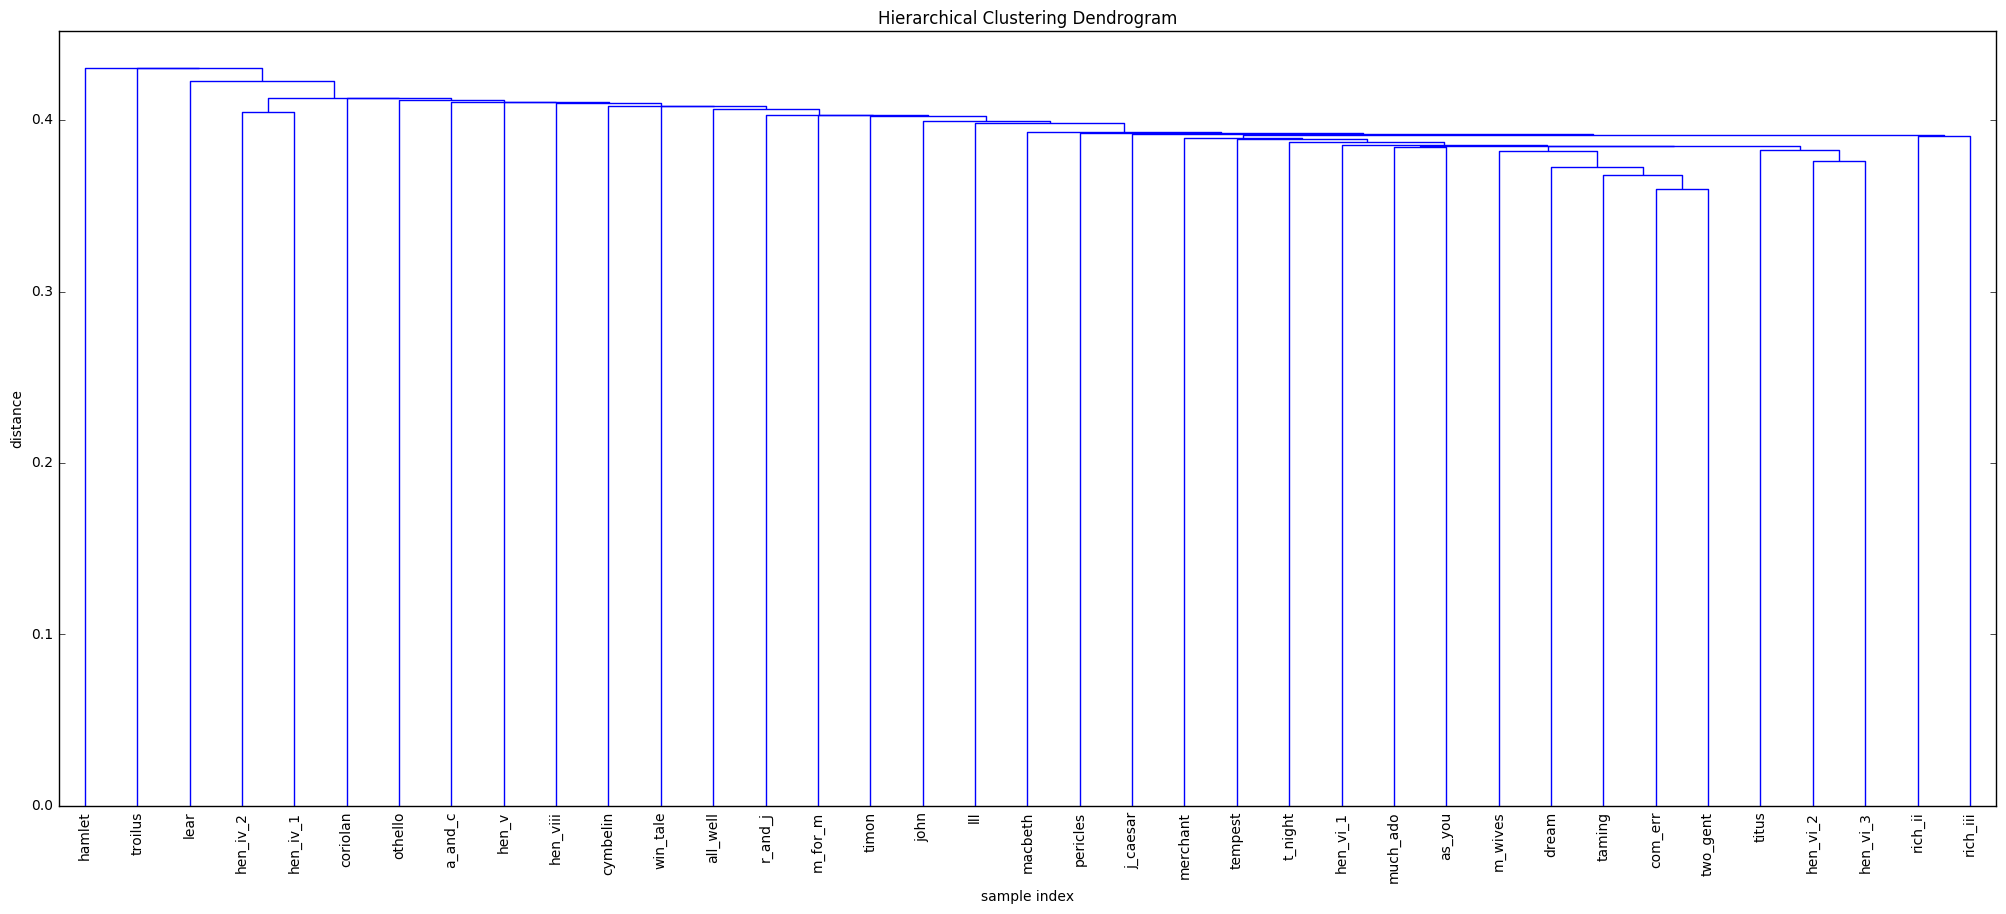

Method: Single, Metric:  dice
Cophenetic Correlation Coefficient:  0.352047493472


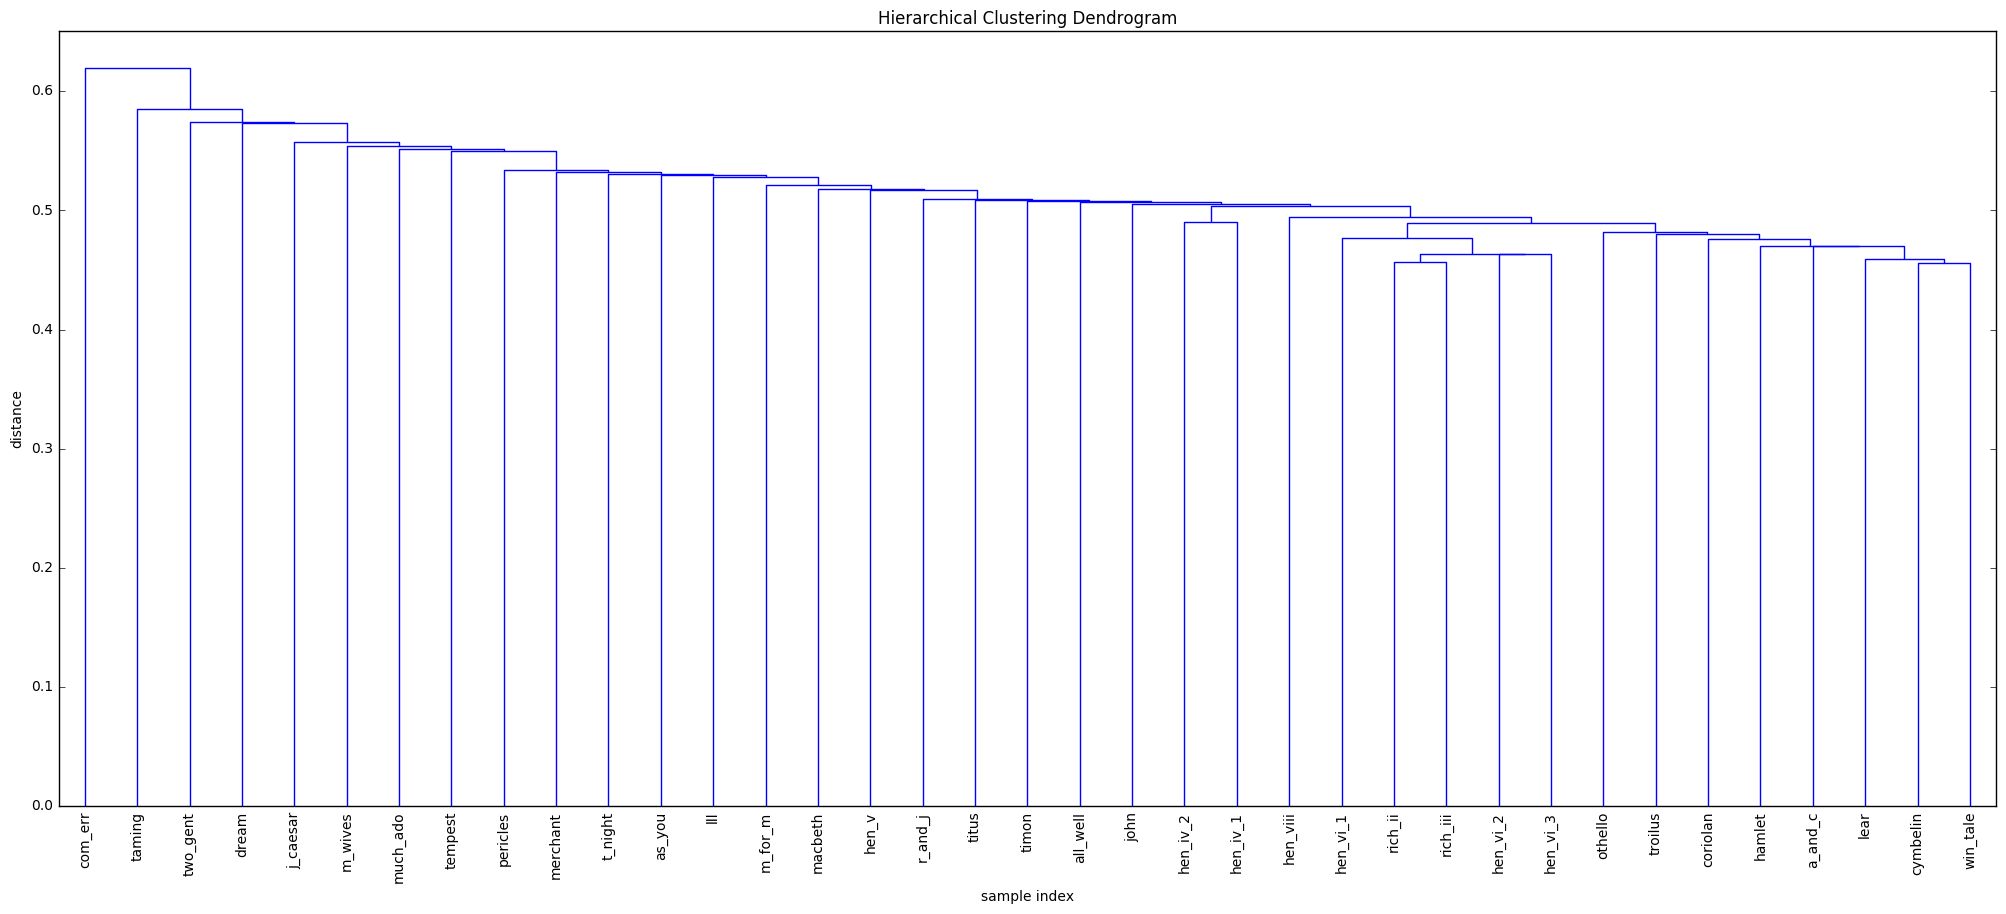

Method: Single, Metric:  kulsinski
Cophenetic Correlation Coefficient:  0.314450534173


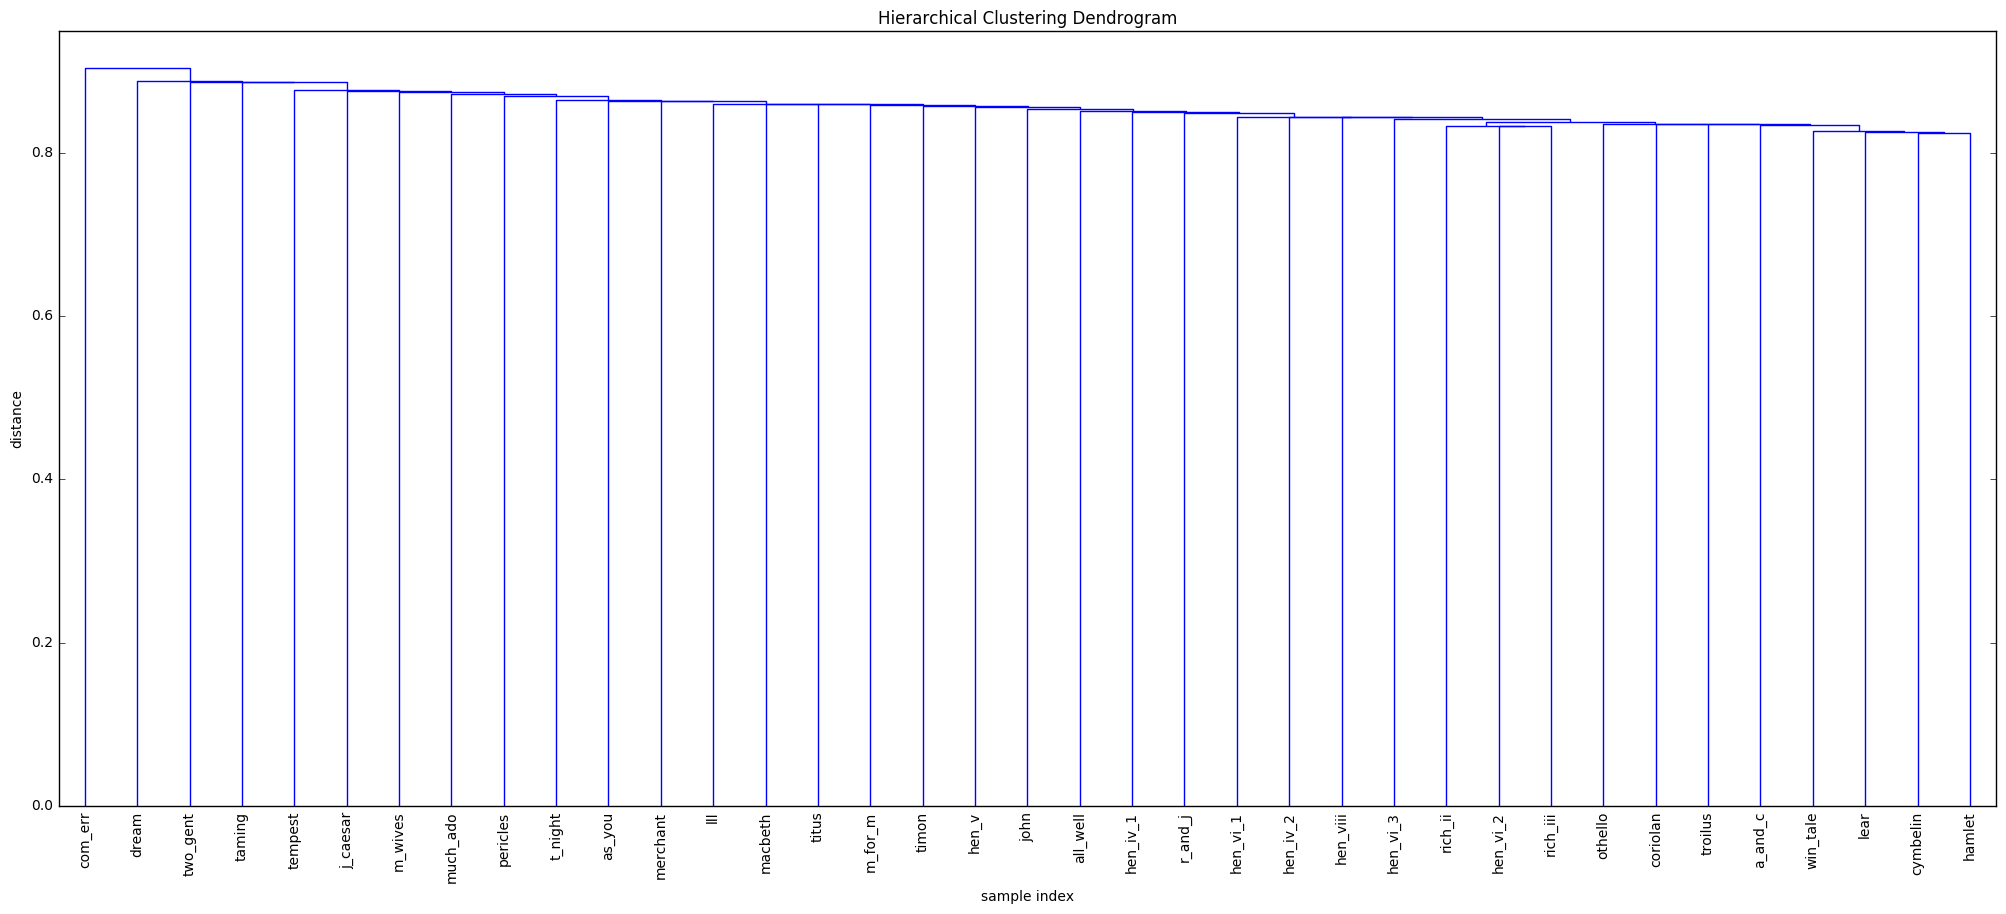

Method: Single, Metric:  rogerstanimoto
Cophenetic Correlation Coefficient:  -0.0751320140186


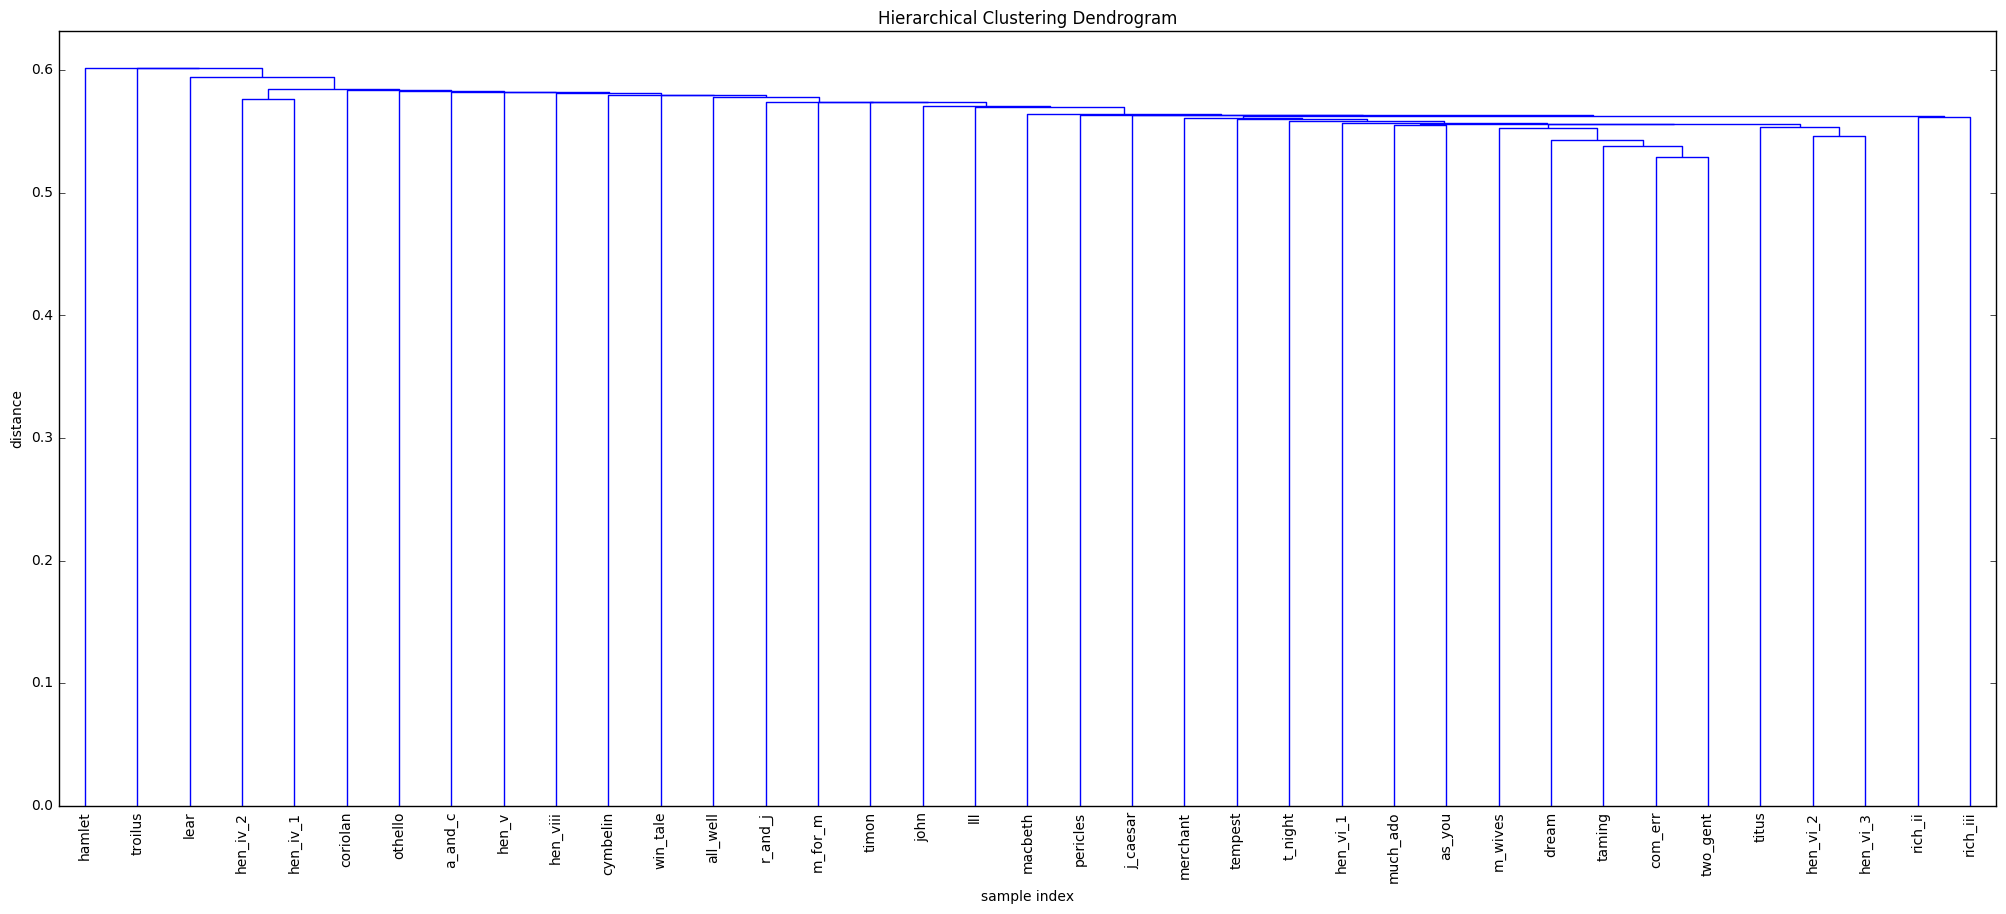

In [22]:

metrics = ['euclidean', 'minkowski', 'cityblock', 'seuclidean', 'sqeuclidean', 'cosine', 
           'correlation', 'hamming', 'jaccard', 'yule', 'matching', 'dice', 'kulsinski', 'rogerstanimoto']

for metric in metrics:
    print('Method: Single, Metric: ', metric)
    display_dendogram(tfidf_matrix_plays.todense(), 
                      list(frame_plays.title), method='single', metric=metric)


Cophenetic Correlation Coefficient:  0.827182022649


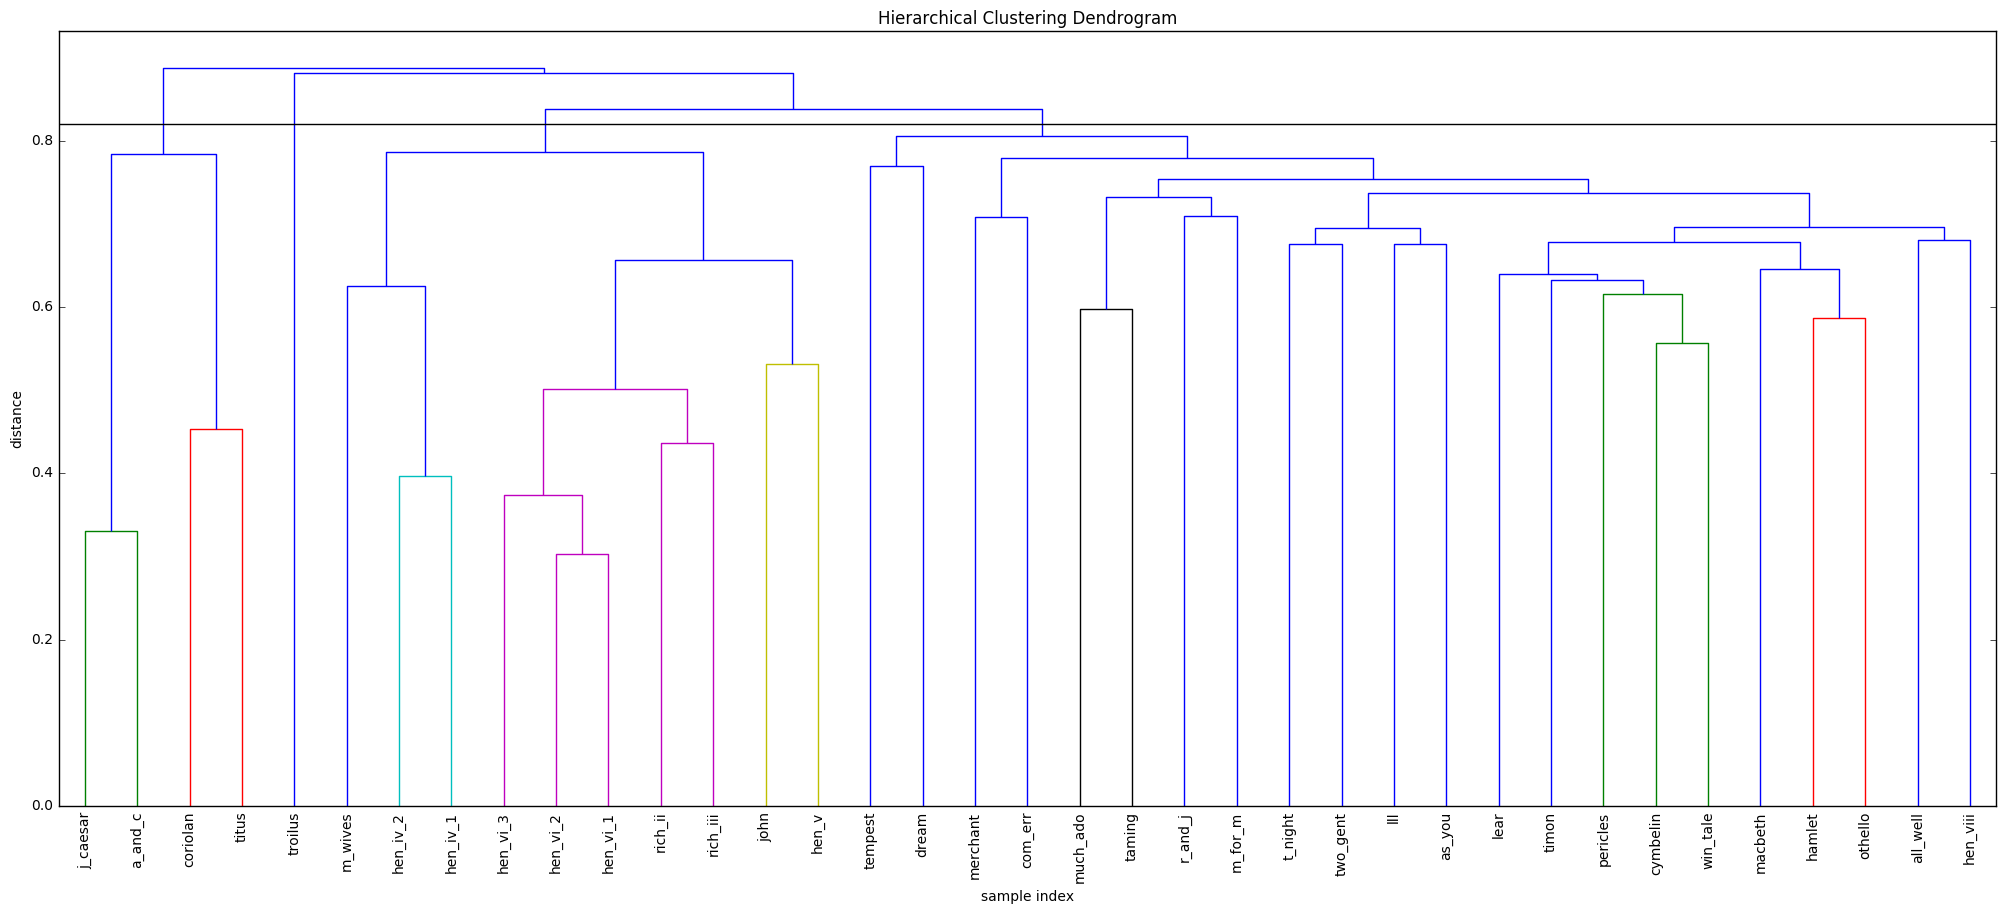

In [23]:

display_dendogram(tfidf_matrix_plays.todense(), 
                  list(frame_plays.title), method='weighted', metric='cosine', cutoff=0.82)



Cophenetic Correlation Coefficient:  0.552116938749


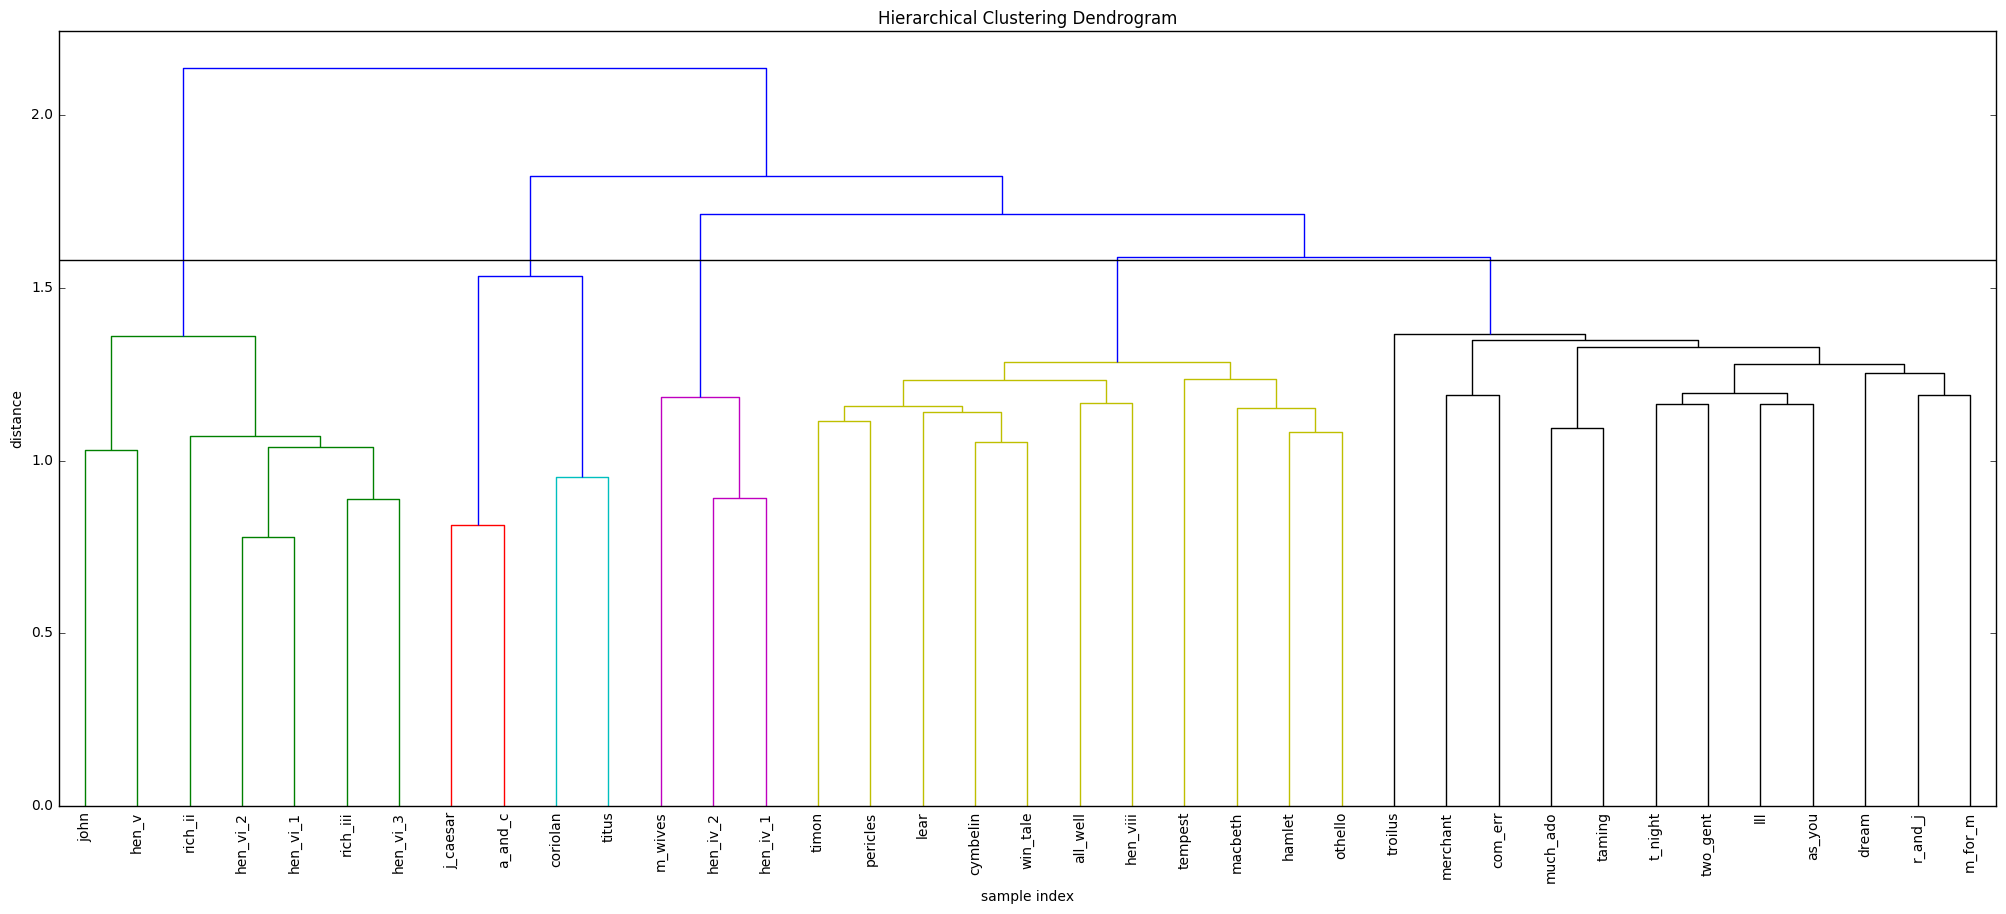

In [24]:
display_dendogram(tfidf_matrix_plays.todense(), 
                  list(frame_plays.title), method='ward', metric='euclidean', cutoff=1.58)

<a id='silhouette_details'></a>

## Silhouette Plots

In [55]:
#print((kms_df_speakers.cluster_labels))

In [26]:
from sklearn.metrics import silhouette_score

def silhouette_plot(kms, X):
    """
    http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    range_n_clusters = range(len(kms))
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        #cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        cluster_labels = kms.cluster_labels.values
        
        print(X)
        print(kms)
        
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = kms.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

In [27]:
#print(kms_df_plays)
#print(kms_df_plays.cluster_labels.values)
len(kms_df_plays[-1:])

1

In [32]:
#silhouette_plot(kms_df_plays[-1:], tfidf_matrix_plays)

<a id='stemming_details'></a>

### Stemming

We rerun the K-Means and MDS plot but with stemming turned on

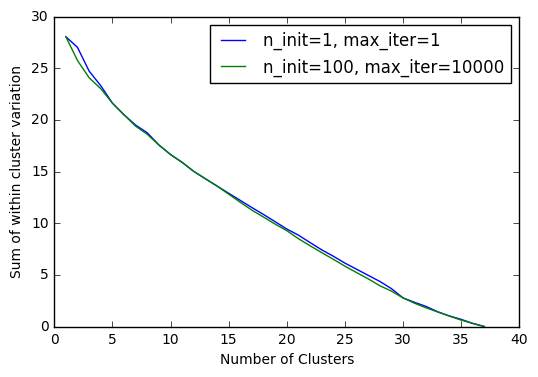

In [33]:
#plays_utterances = ds.get_by_play()
tfidf_matrix_plays_stemmed, terms_plays_stemmed = run_tfidf(plays_utterances.values(), stem=True)


# Run using poor parameters
kms_df_plays_stemmed1_1 = run_single_kmeans(tfidf_matrix_plays_stemmed, 
                                         n_init=1, max_iter=1,
                                         range_clusters = range(1,38), title='plays')
    
# Run again using a decent max_iter and n_init
kms_df_plays_stemmed = run_single_kmeans(tfidf_matrix_plays_stemmed, 
                                 range_clusters = range(1,38), title='plays')

plot_two(kms_df_plays_stemmed1_1, 'n_init=1, max_iter=1', 
         kms_df_plays_stemmed, 'n_init=100, max_iter=10000')



In [34]:
tfidf_matrix_plays_stemmed.shape[0]

37

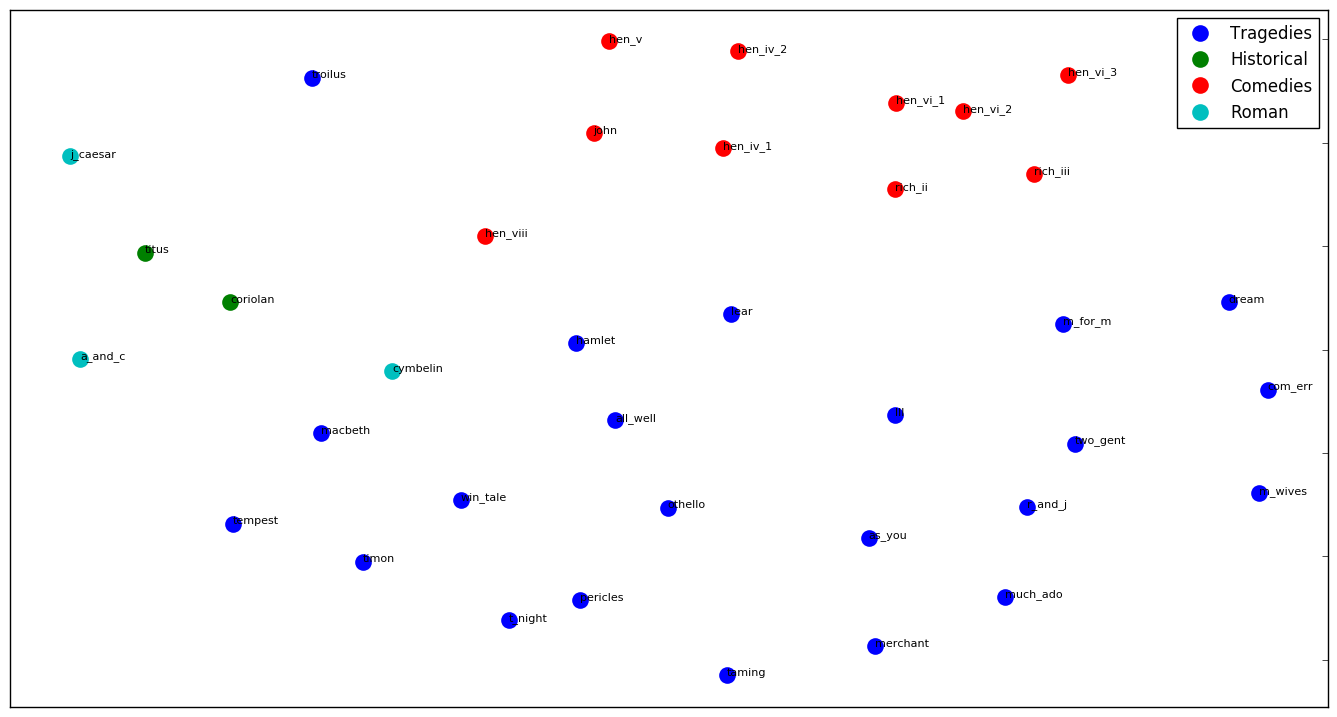

In [35]:
cluster_names_play_stem = {0: 'Tragedies', 
                           1: 'Historical', 
                           2: 'Comedies', 
                           3: 'Roman'}
# From the diagram, above, it looks like there may be an elbow around 4
frame_plays_stemmed = make_frame(plays_utterances, kms_df_plays_stemmed.iloc[3].clusters)

dist_plays_stemmed, xs_plays_stemmed, ys_plays_stemmed = calc_mds(tfidf_matrix_plays_stemmed)

display_mds_plot(frame_plays_stemmed, xs_plays_stemmed, ys_plays_stemmed, cluster_names_play_stem)

## PCA

In [36]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
set2_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

bold_colors = ['#FF0000', '#00FF00', '#FFAAAA', '#0000FF']
light_colors = ['#FFAAAA', '#AAFFAA', '#AAAAFF', '#00FF00']
cmap_light = ListedColormap(light_colors)
cmap_bold = ListedColormap(bold_colors)
dark2_cmap = ListedColormap(dark2_colors)
set2_cmap = ListedColormap(dark2_colors)
light_grey = np.array([float(248)/float(255)]*3)
shade_black = '#262626'

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 16
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
def cible_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Make a target axis at 0,0 with ticks along the axis lines
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [37]:
#print(tfidf_matrix_speakers[0][0])
#print(tfidf_matrix_speakers.shape, len(terms_speakers))

In [38]:
tfidf_matrix_speakers_pca = tfidf_matrix_speakers.A
terms_speakers_pca = terms_speakers
df = pd.DataFrame()
df = pd.DataFrame(data=tfidf_matrix_speakers_pca, columns=terms_speakers_pca)
#df

In [39]:
from sklearn import neighbors, decomposition, metrics, preprocessing

df_scaled = df.copy()
df_scaled.iloc[:,:] = preprocessing.StandardScaler().fit_transform(df_scaled.iloc[:,:])
#df_scaled.describe()

In [40]:
import sklearn

pca = sklearn.decomposition.PCA(n_components=100).fit(df_scaled.iloc[:,:])

coef_PCA = pca.transform(df_scaled.iloc[:,:])
# we make a scree plot to see how many Principal Components to consider
plt.figure(figsize=(12, 6))
eig = pca.explained_variance_
# and calculate the variance explained by the PC analysis
var_exp = pca.explained_variance_ratio_.cumsum()*100.

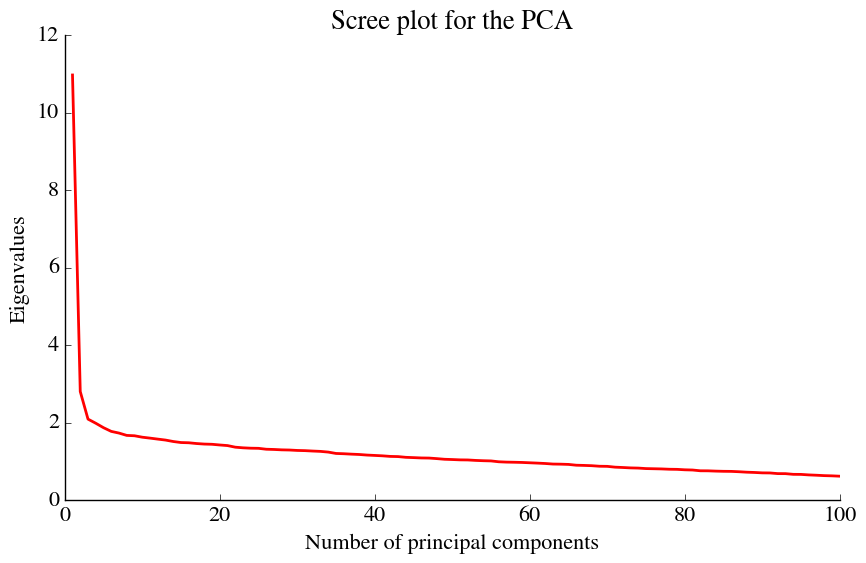

In [41]:
plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()
plt.show()

In [42]:
print ('The First Principal Component explains\t\t {:03.1f} % of the variance'.format(var_exp[0]))
print ('The First 2 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[1]))
print ('The First 3 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[2]))
print ('The First 4 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[3]))
print ('The First 6 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[5]))
print ('The First 10 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[9]))
print ('The First 20 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[19]))
print ('The First 40 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[39]))
print ('The First 100 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[99]))

The First Principal Component explains		 7.6 % of the variance
The First 2 Principal Components explain	 9.6 % of the variance
The First 3 Principal Components explain	 11.0 % of the variance
The First 4 Principal Components explain	 12.4 % of the variance
The First 6 Principal Components explain	 15.0 % of the variance
The First 10 Principal Components explain	 19.6 % of the variance
The First 20 Principal Components explain	 30.1 % of the variance
The First 40 Principal Components explain	 47.9 % of the variance
The First 100 Principal Components explain	 84.4 % of the variance


In [43]:
speakers_utterances_frame = pd.DataFrame.from_dict(speakers_utterances, orient='index')

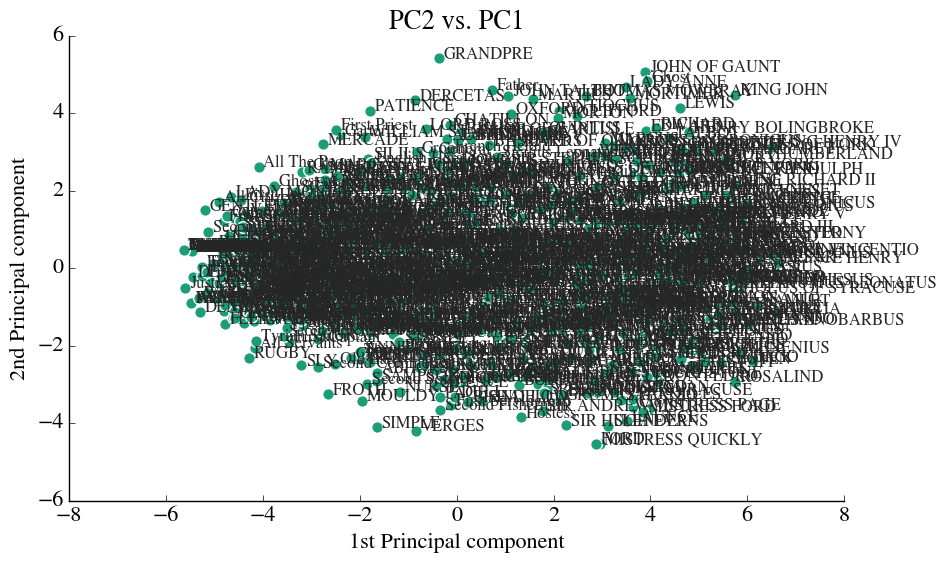

In [44]:
plt.figure(figsize=(10,6))
plt.scatter(coef_PCA[:,0], coef_PCA[:,1], s = 70, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    plt.text(coef_PCA[i,0]+.1, coef_PCA[i,1], speakers_utterances_frame.ix[i].name,  zorder=1, size=12, color=shade_black)  
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
remove_border()
plt.show()

In [45]:
tfidf_matrix_plays_pca = tfidf_matrix_plays.A
terms_plays_pca = terms_plays
df = pd.DataFrame()
df = pd.DataFrame(data=tfidf_matrix_plays_pca, columns=terms_plays_pca)

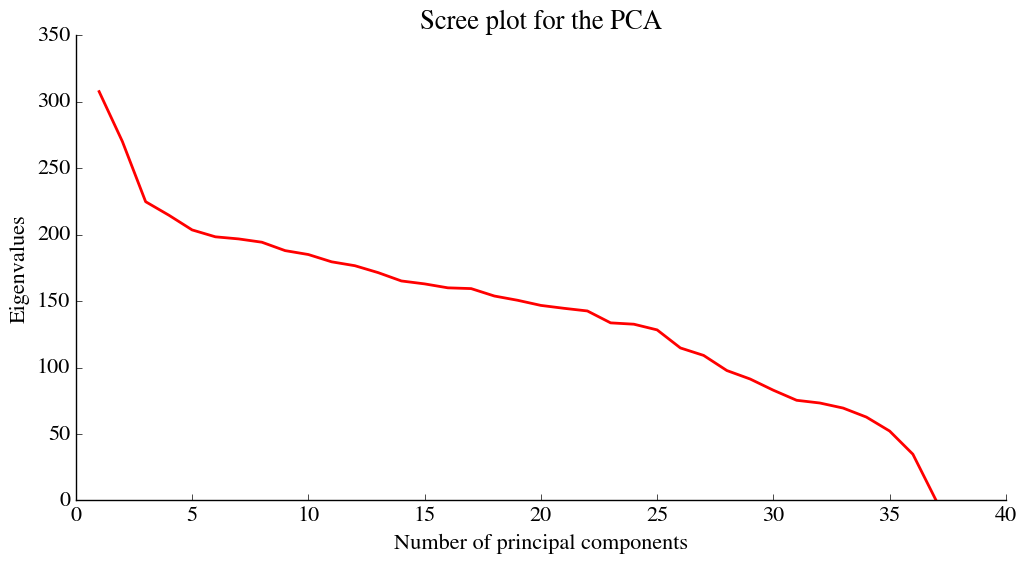

In [46]:
df_scaled = df.copy()
df_scaled.iloc[:,:] = preprocessing.StandardScaler().fit_transform(df_scaled.iloc[:,:])

pca = sklearn.decomposition.PCA(n_components=100).fit(df_scaled.iloc[:,:])

coef_PCA = pca.transform(df_scaled.iloc[:,:])
plt.figure(figsize=(12, 6))
eig = pca.explained_variance_
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()
plt.show()

In [47]:
print ('The First Principal Component explains\t\t {:03.1f} % of the variance'.format(var_exp[0]))
print ('The First 2 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[1]))
print ('The First 3 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[2]))
print ('The First 4 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[3]))
print ('The First 6 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[5]))
print ('The First 10 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[9]))
print ('The First 20 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[19]))
print ('The First 30 Principal Components explain\t {:03.1f} % of the variance'.format(var_exp[29]))

The First Principal Component explains		 5.7 % of the variance
The First 2 Principal Components explain	 10.8 % of the variance
The First 3 Principal Components explain	 15.0 % of the variance
The First 4 Principal Components explain	 19.0 % of the variance
The First 6 Principal Components explain	 26.5 % of the variance
The First 10 Principal Components explain	 40.8 % of the variance
The First 20 Principal Components explain	 71.1 % of the variance
The First 30 Principal Components explain	 93.1 % of the variance


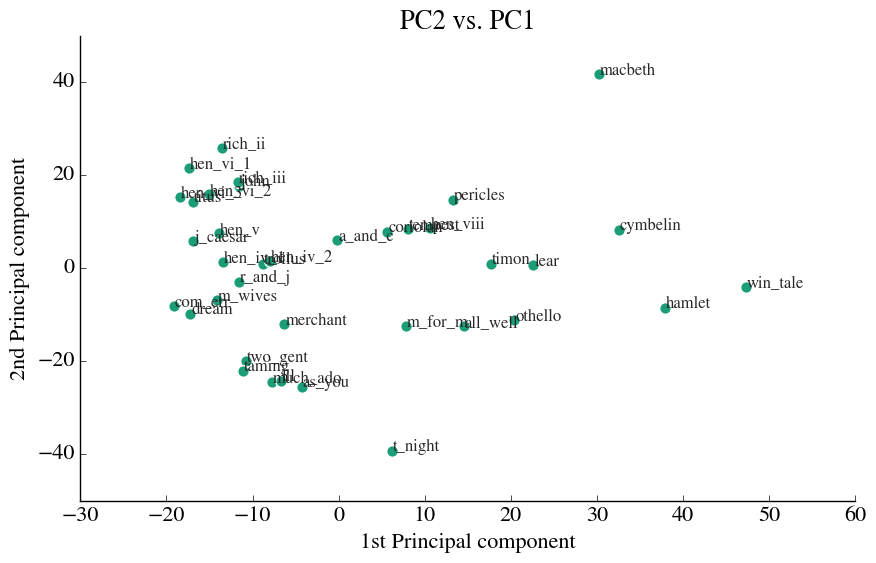

In [48]:
plays_utterances_frame = pd.DataFrame.from_dict(plays_utterances, orient='index')

plt.figure(figsize=(10,6))
plt.scatter(coef_PCA[:,0], coef_PCA[:,1], s = 70, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    plt.text(coef_PCA[i,0]+.1, coef_PCA[i,1], plays_utterances_frame.ix[i].name,  zorder=1, size=12, color=shade_black)  
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
remove_border()
plt.show()

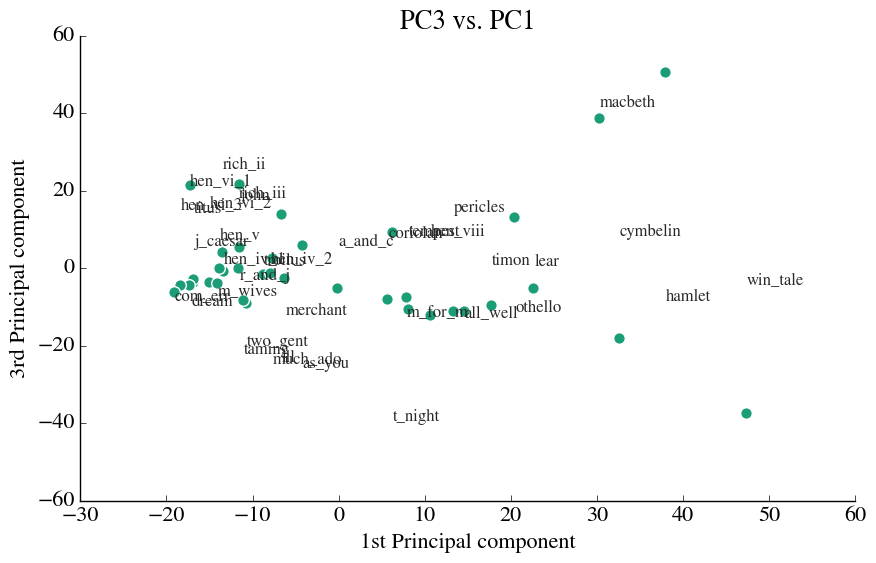

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(coef_PCA[:,0], coef_PCA[:,2], s = 70, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    plt.text(coef_PCA[i,0]+.1, coef_PCA[i,1], plays_utterances_frame.ix[i].name,  zorder=1, size=12, color=shade_black)  
plt.ylabel('3rd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC3 vs. PC1')
remove_border()
plt.show()

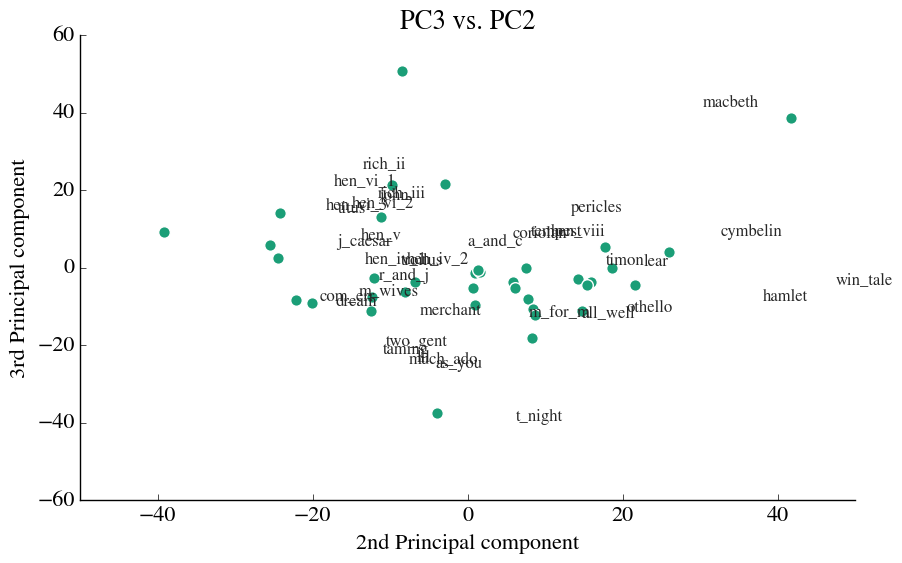

In [50]:
plt.figure(figsize=(10,6))
plt.scatter(coef_PCA[:,1], coef_PCA[:,2], s = 70, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    plt.text(coef_PCA[i,0]+.1, coef_PCA[i,1], plays_utterances_frame.ix[i].name,  zorder=1, size=12, color=shade_black)  
plt.ylabel('3rd Principal component' )
plt.xlabel('2nd Principal component' )
plt.title('PC3 vs. PC2')
remove_border()
plt.show()

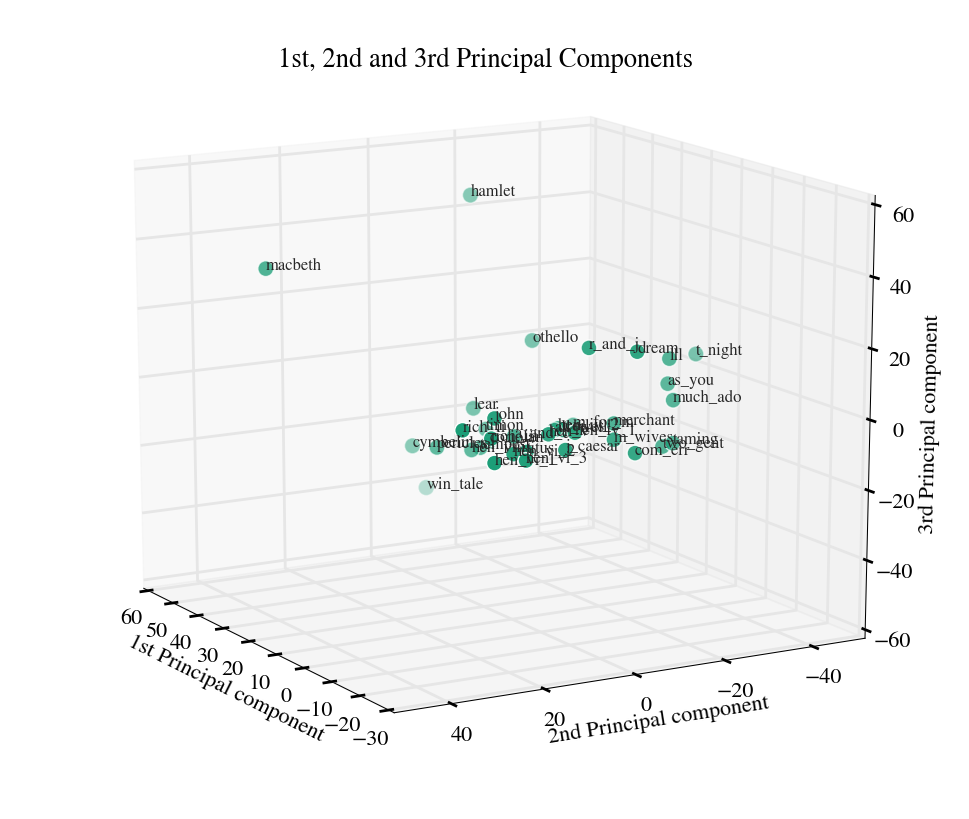

In [51]:
#import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=15, azim=150)
plt.cla()

ax.scatter(coef_PCA[:,0], coef_PCA[:,1], coef_PCA[:,2], s = 130, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    ax.text(coef_PCA[i,0], coef_PCA[i,1], coef_PCA[i,2], plays_utterances_frame.ix[i].name, zorder=1, size=12, color=shade_black) 

ax.set_xlabel('1st Principal component')
ax.set_ylabel('2nd Principal component')
ax.set_zlabel('3rd Principal component')
ax.set_title('1st, 2nd and 3rd Principal Components')
plt.show()

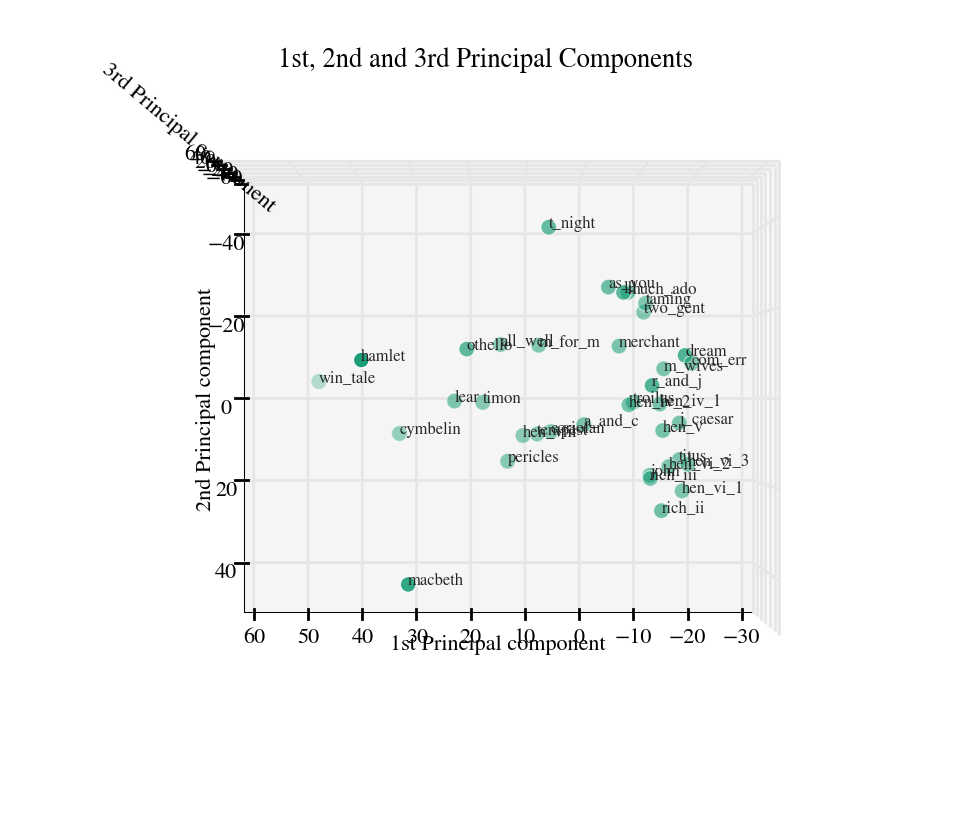

In [52]:
#import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=90, azim=90)
plt.cla()

ax.scatter(coef_PCA[:,0], coef_PCA[:,1], coef_PCA[:,2], s = 130, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    ax.text(coef_PCA[i,0], coef_PCA[i,1], coef_PCA[i,2], plays_utterances_frame.ix[i].name, zorder=1, size=12, color=shade_black) 

ax.set_xlabel('1st Principal component')
ax.set_ylabel('2nd Principal component')
ax.set_zlabel('3rd Principal component')
ax.set_title('1st, 2nd and 3rd Principal Components')
plt.show()

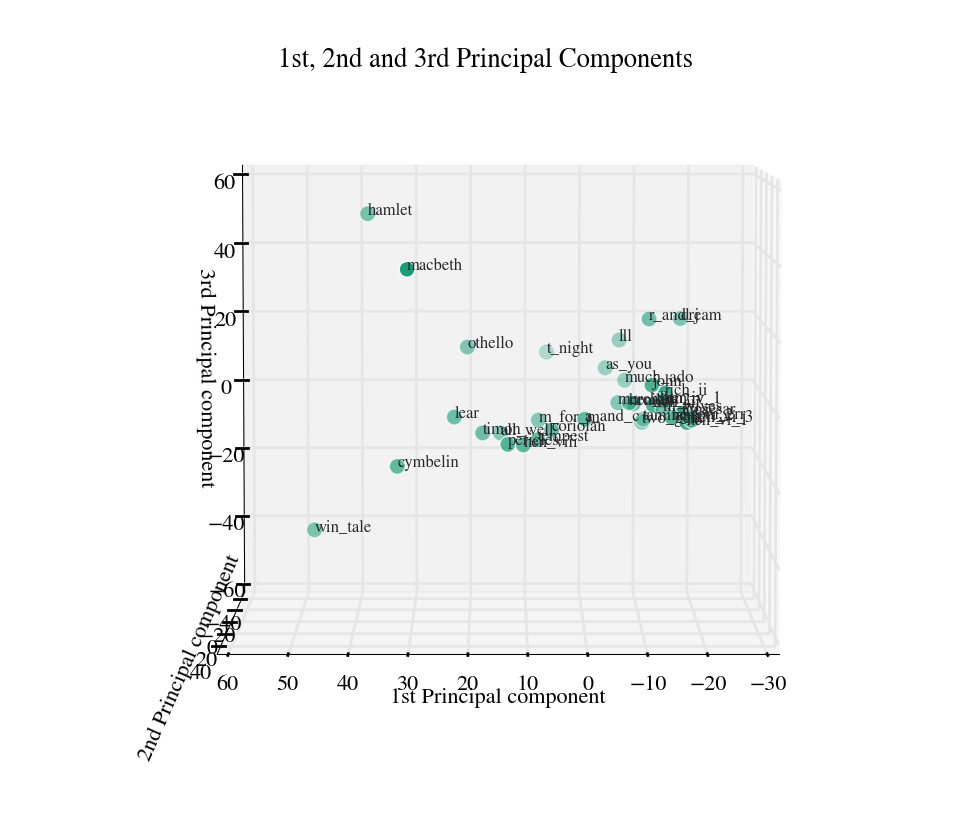

In [53]:
#import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=5, azim=90)
plt.cla()

ax.scatter(coef_PCA[:,0], coef_PCA[:,1], coef_PCA[:,2], s = 130, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    ax.text(coef_PCA[i,0], coef_PCA[i,1], coef_PCA[i,2], plays_utterances_frame.ix[i].name, zorder=1, size=12, color=shade_black) 

ax.set_xlabel('1st Principal component')
ax.set_ylabel('2nd Principal component')
ax.set_zlabel('3rd Principal component')
ax.set_title('1st, 2nd and 3rd Principal Components')
plt.show()

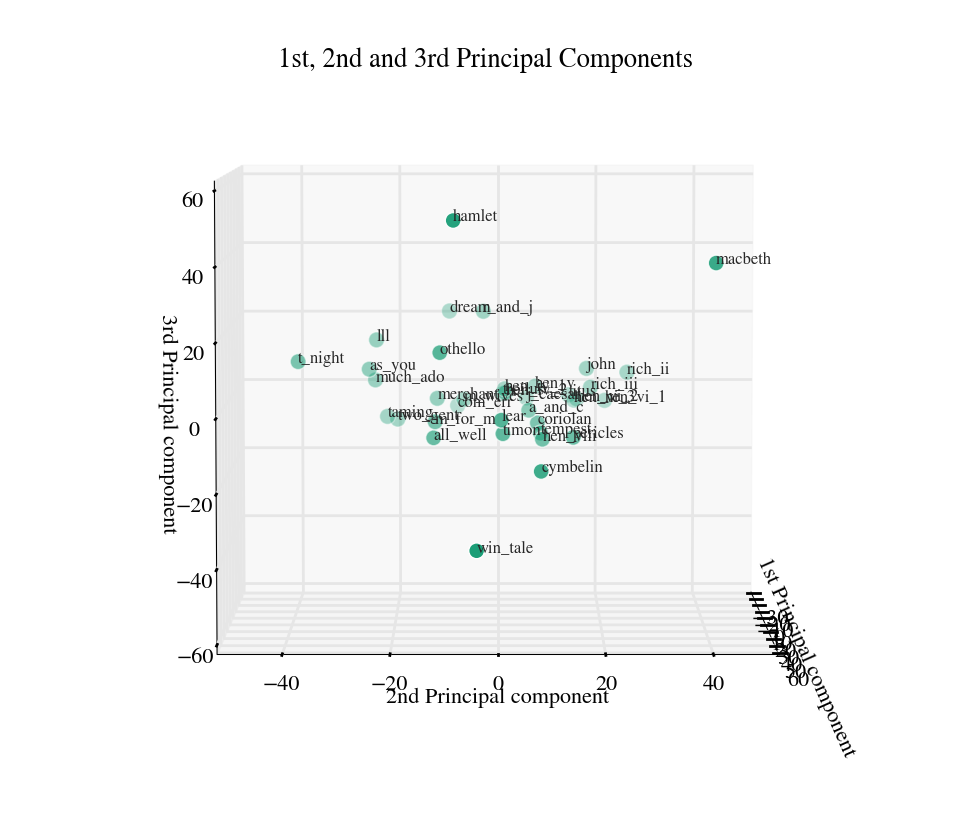

In [54]:
#import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=5, azim=0)
plt.cla()

ax.scatter(coef_PCA[:,0], coef_PCA[:,1], coef_PCA[:,2], s = 130, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    ax.text(coef_PCA[i,0], coef_PCA[i,1], coef_PCA[i,2], plays_utterances_frame.ix[i].name, zorder=1, size=12, color=shade_black) 

ax.set_xlabel('1st Principal component')
ax.set_ylabel('2nd Principal component')
ax.set_zlabel('3rd Principal component')
ax.set_title('1st, 2nd and 3rd Principal Components')
plt.show()

<a id='exploratory_points'></a>